# Things to explore

**Regarding datasets:**
- Key question: Understanding why raw data is different than curated promoters
- Using Donghui’s or other raw data - let's start by collecting and organizing our target datasets.
- Extract *‘types’* of TSS from raw data (Donghui did this - just a matter of location or anything with signal strength?)  
    - currently have four types regarding positions
    - using the signal strength as type classification vs adding the signal strength as features
- Activity level of TSS - from expression or read data?
    - how to add this as features 
    
    
- Using annotated TRN data to help find promoters - TF binding sites should be located around the promoter  


**Regarding later data arrangement:**
- How does the reconstruction empower this ML effort? (promoter typing etc)
- Categorizing labels (different types of TSS) to try to improve resolution
    - after extracting types 


**Regarding ML:**
- Feature selections for curve and shape
    - determine the region for calculation (upstream, spacer, etc.)
    - determine max, range, mean to use.
    - reduce features by feature importance
    - reduce features by ICA or PCA
- The threshold doesn't seem to help - negatives and positives have similar mean 
    - anything other than statistic that could do a smart screening
    - maybe undersampling method?

- Some tss close to the real tss showing very similar score to the true tss
    - should we not include those in the negative set? like a wiggle room for the training set
    - topk scores in similar places (also because of spacer_lenth range?)
    - apply probability threshold: how many location > X probability.



# Immediate Plan:
- Fix the feature calculation - only include the spacer/AT/UTR for the most likely sigma
- Organize Donghui's two TSS dataset
    - how do we compare raw data vs curated data (W3110)
    - how does the minimun dataset align with W3110
    - how to process RPM data.
- more raw datasets?

In [30]:
# built-in
from pathlib import Path
import matplotlib.pyplot as plt
import sys
import time as Time

# third-party (install required)
import numpy as np
import pandas as pd
import seaborn as sns
from statistics import mean
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from scipy.stats import pearsonr
# from yellowbrick.model_selection import RFECV

from sklearn.utils import compute_class_weight

import dnacurve

from numpy import inf

import shap

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from collections import Counter
from Bio.SeqUtils import GC

# local modules
sys.path.append('../../bitome2')

from bitome.core import Bitome

# define paths
K12_DATA_PATH = Path('../data/bitome2/mg1655')


# Construct K-12 MG1655 Bitome

In [2]:
# from GenBank annotation
origin = (3925743, 3925975)
# from 1. Duggin, I. G. & Bell, S. D. J. Mol. Biol. (2009). with the following terA/terC sequences:
# ter_a = 'AATTAGTATGTTGTAACTAAAGT'
# ter_c = 'ATATAGGATGTTGTAACTAATAT'
terminus = (1341745, 1609180)
cid_boundaries = [50000, 142779, 223485, 446815, 927474, 985894, 1080000, 1195008, 1301085, 1577657,
                 1799393, 1852621, 2102875, 2259719, 2380722, 2533498, 2726069, 2905711, 2996372, 3297098,
                 3423423, 3440040, 3652182, 3811250, 3941516, 4035239, 4166484, 4470986]

In [3]:
mg1655 = Bitome(
    Path(K12_DATA_PATH, 'NC_000913.3.gb'),
    name='MG1655',
    origin=origin, terminus=terminus,
    cid_boundaries=cid_boundaries,
    gene_table=Path(K12_DATA_PATH, 'gene_info_supp.csv'),
    tu_table=Path(K12_DATA_PATH, 'tu.csv'),
    operon_table=Path(K12_DATA_PATH, 'operon.csv'),
    tss_table=Path(K12_DATA_PATH, 'tss.csv'),
    tfbs_table=Path(K12_DATA_PATH, 'tfbs.csv'),
    terminator_table=Path(K12_DATA_PATH, 'terminator.csv'),
    attenuator_table=Path(K12_DATA_PATH, 'attenuator.csv'),
    rbs_table=Path(K12_DATA_PATH, 'rbs.csv'),
    riboswitch_table=Path(K12_DATA_PATH, 'riboswitch.csv')
)

# Scording function

## Create dataset contain 250 upstream of every gene

In [47]:
def one_hot_encode_sequence(seq):
    base_to_ind = dict(zip('ACGT', range(4)))    
    seq_mapped = [base_to_ind[base] for base in seq]
    return np.eye(4)[seq_mapped]

def create_data_array(sequence_df):

    # initialize a Numpy array to store the one-hot encoded sequences
    # should have shape: (n_examples, sequence_length, 4 (for bases))
    data_array = np.empty((sequence_df.shape[0], len(sequence_df.loc[0, 'seq']), 4))

    # for each sequence in the sequence DF, prepare the one-hot version
    for i, sequence in enumerate(sequence_df['seq']):
        data_array[i] = one_hot_encode_sequence(sequence)
    
    return data_array

def create_sweep_dataset(n_upstream=250, n_downstream=25, bitome_obj=mg1655):
    
    # get the TU info where we have high-confidence TSS annotation
    tu_with_tss_df = bitome_obj.tu_table[bitome_obj.tu_table['tss'].notna()].drop_duplicates(subset='tss')
    tu_with_tss_df.head()
    
    closest_gene_tss_rows = []

    # for each TU with a TSS, get the closest gene start
    for tu_with_tss_row in tu_with_tss_df.itertuples():

        # get the genes for this TU; want the closest one
        tu_genes = bitome_obj._tu_to_genes[tu_with_tss_row.Index]
        tu_gene_df = bitome_obj.gene_table.loc[tu_genes]
        if tu_gene_df.empty:
            continue
        if tu_with_tss_row.strand == 1:
            gene_starts = tu_gene_df['left']
        else:
            gene_starts = tu_gene_df['right']
        closest_start_idx = np.argmin(np.abs(np.array(gene_starts) - tu_with_tss_row.tss))
        closest_start = gene_starts[closest_start_idx]
        closest_gene_row = tu_gene_df.iloc[closest_start_idx]
        
        # determine the left/right ends of our range based on strand
        if tu_with_tss_row.strand == 1:
            left, right = closest_start - n_upstream, closest_start + n_downstream
        else:
            left, right = closest_start - n_downstream, closest_start + n_upstream

        # now we have the closest start; we can record this search range in absolute coordinates
        closest_gene_tss_rows.append({
            'closest_gene': closest_gene_row.name,
            'tu': tu_with_tss_row.Index,
            'tss': tu_with_tss_row.tss,
            'left': left,
            'right': right,
            'strand': tu_with_tss_row.strand,
            'sigma_factor': tu_with_tss_row.sigma_factor
        })

    closest_gene_tss_df = pd.DataFrame(closest_gene_tss_rows)
    
    # now we may have multiple rows for the same left-right promoter region have the same closest gene
    # that's fine, let's group by these to make a final dataset that collapses the TSSes 
    # we can also make the labels here (one per base pair)

    sequence_rows = []
    label_rows = []

    for gene, gene_tss_df in closest_gene_tss_df.groupby('closest_gene'):

        # extract the appropriate promoter search range; ignore the thrL edge case for now
        gene_tss_first_row = gene_tss_df.iloc[0]
        if gene_tss_first_row['left'] < 1:
            continue
        prom_range_sequence = bitome_obj.get_sequence(
            gene_tss_first_row['left'], gene_tss_first_row['right'], gene_tss_first_row['strand']
        )
        # we actually want to "start" (i.e. have the model's first time step) be at the gene itself
        # so we have to flip this sequence here
        prom_range_sequence = prom_range_sequence[::-1]
        
        # now let's set up the label vector; this should match the REVERSED order of the sequence
        # i.e. should start downstream and go upstream; this means we only have to reverse for the 
        # forward strand, because left to right IS down to upstream on -1 strand
        prom_range_poses = np.arange(gene_tss_first_row['left'], gene_tss_first_row['right'] + 1)
        if gene_tss_first_row['strand'] == 1:
            prom_range_poses = np.flip(prom_range_poses)
        label_vector = np.zeros(prom_range_poses.shape)
        for tss in gene_tss_df['tss']:
            label_vector[np.argwhere(prom_range_poses == tss)] = 1

        # now let's add to our running list of data info and labels
        sequence_rows.append({
            'gene': gene,
            'left': gene_tss_first_row['left'],
            'right': gene_tss_first_row['right'],
            'strand': gene_tss_first_row['strand'],
            'seq': str(prom_range_sequence),
            'tsses': list(gene_tss_df['tss']),
            'tus': list(gene_tss_df['tu'])
        })
        label_rows.append(label_vector)

    prom_range_seq_df = pd.DataFrame(sequence_rows)
    label_cols = np.flip(np.arange(-n_upstream, n_downstream + 1))
    label_df = pd.DataFrame(
        label_rows,
        index=prom_range_seq_df['gene'],
        columns=label_cols,
        dtype=int
    )

    # create an ML-ready data array for just the one-hot encoded sequences
    prom_range_data_array = create_data_array(prom_range_seq_df)
    
    return prom_range_seq_df, prom_range_data_array, label_df

In [48]:
prom_range_seq_df, prom_range_data_array, label_df = create_sweep_dataset(n_upstream=250, n_downstream=0)

## Shape (in a range) calculation 

In [6]:
fivemer_shape_df = pd.read_csv('../data/5mer_shape_lookup.csv', index_col=0)

fivemer_shape_df

,Opening,Rise,Stretch,EP,Tilt,Shear,ProT,Buckle,Shift,HelT,Stagger,Slide,MGW,Roll
AAAAA,-3.71,3.250,0.03,-10.10,-0.970,0.18,-16.51,7.80,-0.140,37.875,-0.22,-0.980,3.38,-5.070
AAAAC,-1.90,3.200,-0.01,-8.97,-1.405,0.15,-14.47,9.07,0.010,37.040,-0.06,-1.060,4.05,-4.210
AAAAG,-2.30,3.235,0.01,-10.39,-1.475,0.17,-14.68,7.39,0.045,37.100,-0.13,-1.140,3.68,-5.350
AAAAT,-2.05,3.275,-0.01,-10.80,-1.280,0.17,-14.89,7.97,0.030,37.305,-0.10,-1.150,3.63,-4.340
AAACA,-1.30,3.280,-0.01,-8.05,-0.960,0.15,-13.05,11.53,0.250,35.905,0.13,-1.300,4.65,-2.935
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGT,-1.70,3.300,-0.03,-7.86,-0.225,-0.09,-12.03,-2.71,0.315,35.590,-0.25,-1.095,5.21,1.765
TTTTA,-2.26,3.175,-0.02,-8.39,0.855,-0.15,-13.29,-7.24,0.180,36.160,-0.11,-1.050,4.89,-2.605
TTTTC,-2.28,3.200,-0.01,-9.65,1.080,-0.16,-13.16,-6.00,0.210,36.660,-0.16,-1.035,4.35,-3.995
TTTTG,-2.39,3.190,-0.03,-8.76,1.270,-0.15,-13.79,-7.51,0.120,36.215,-0.11,-1.040,4.76,-2.475


In [7]:
def get_dna_shape(left, right, strand, bitome_obj=mg1655):
    """
    Given a position, compute all 14 shape params
    """

    seq = bitome_obj.get_sequence(left-2, right+2, strand)
    seq_fivemers = [str(seq[i:i+5]) for i in range(len(seq) - 5 + 1)]
    seq_fivemer_shape_df = fivemer_shape_df.loc[seq_fivemers]
    
    return seq_fivemer_shape_df

## Motif score (in a range) calculation

In [8]:
def motif_range_score(left: int, right: int, strand: int, bitome_obj=mg1655):
    
    # search range is the sliding window size for both -10 and -35 box.
    
    # we assume W3110 sigma factors are similar to mg1655, thus also use the mg1655 motifs.
    all_sigma_motif_dict = mg1655.create_sigma_motifs()
    
    motif_score_dict={}
    
    for sigma_name, sigma_motif_dict in all_sigma_motif_dict.items():
        
        box_10_tss_dists = sigma_motif_dict['b10_tss_lens']

        spacer_lens = sigma_motif_dict['spacer_lens']
        box_35_tss_dists = np.mean(box_10_tss_dists) + np.mean(spacer_lens)
        
        box_10_tss_dists = np.mean(box_10_tss_dists)
        
        # print(sigma_name)
        
        
        if strand == 1:
    
            # look upstream and compute in a sliding window the -10 motif scores around 10 bp upstream of any_base
            score_10 = bitome_obj.motif_search(left, right, strand, sigma_motif_dict['-10'].pssm, n_best_matches=abs(right-left)+50)

            # look upstream and compute in a sliding window the -35 motif scores around 35 bp upstream of any_base
            score_35 = bitome_obj.motif_search(left, right, strand, sigma_motif_dict['-35'].pssm, n_best_matches=abs(right-left)+50)
            
        
        
        else:
            # look upstream and compute in a sliding window the -10 motif scores around 10 bp upstream of any_base
            score_10 = bitome_obj.motif_search(left, right, strand, sigma_motif_dict['-10'].pssm, n_best_matches=abs(right-left)+50)
            
            # look upstream and compute in a sliding window the -35 motif scores around 35 bp upstream of any_base
            score_35 = bitome_obj.motif_search(left, right, strand, sigma_motif_dict['-35'].pssm, n_best_matches=abs(right-left)+50)

        
        sorted_35 = score_35.sort_values('left')
        sorted_10 = score_10.sort_values('left')
    
    
        motif_score_dict[sigma_name] = {'score_10': sorted_10,
                                 'score_35': sorted_35,
                                 'dist_10': round(box_10_tss_dists),
                                 'dist_35': round(box_35_tss_dists)}
    
    return motif_score_dict

# Create Dataset

In [9]:
def tss_sweep_score(any_base_in_range, strand, motif_score_dict, bitome_obj=mg1655, search_range=(3,3), 
                    upstream_range=(-65, -45), UTR_range=60, curvature_range=20):
    # given a base in range and all positive motif_score in that range, return the score for a single loci in that range.
    
    
    #start = Time.time()
    
    score_dict = {}
    
    for sigma_name, sigma_motif_score_dict in motif_score_dict.items():
        #print(sigma_name)

        box_10_dist = sigma_motif_score_dict['dist_10']
        box_35_dist = sigma_motif_score_dict['dist_35']
        box_10_scores = sigma_motif_score_dict['score_10']
        box_35_scores = sigma_motif_score_dict['score_35']
        box_10_length = len(sigma_motif_score_dict['score_10']['match_sequence'][0])
        box_35_length = len(sigma_motif_score_dict['score_35']['match_sequence'][0])
        
        if strand == 1:
    
            # look upstream and compute in a sliding window the -10 motif scores around 10 bp upstream of any_base
            left_10 = any_base_in_range - box_10_dist - box_10_length - search_range[0]
            right_10 = any_base_in_range - box_10_dist + search_range[1]
            
            
            score_10_in_range = box_10_scores.loc[(box_10_scores['left']>left_10) & (box_10_scores['right']<right_10), :]
            
            # print(left_10, right_10, score_10_in_range)
            
            score_10_best_idx = score_10_in_range['log_odds'].idxmax(axis=0)
            
            score_10_best = score_10_in_range.loc[score_10_best_idx, :]

            left_35 = any_base_in_range - box_35_dist - box_35_length - search_range[0]
            right_35 = any_base_in_range - box_35_dist + search_range[1]
            
            # look upstream and compute in a sliding window the -35 motif scores around 35 bp upstream of any_base
            score_35_in_range = box_35_scores.loc[(box_35_scores['left']>left_35) & (box_35_scores['right']<right_35), :]
            score_35_best_idx = score_35_in_range['log_odds'].idxmax(axis=0)
            score_35_best = score_35_in_range.loc[score_35_best_idx, :]
            
            spacer_length = max([score_10_best['left']-score_35_best['left'], 0])

        
        
        else:
            left_10 = any_base_in_range + box_10_dist - search_range[0]
            right_10 = any_base_in_range + box_10_dist + box_10_length + search_range[1]
            
            
            score_10_in_range = box_10_scores.loc[(box_10_scores['left']>left_10) & (box_10_scores['right']<right_10), :]
            score_10_best_idx = score_10_in_range['log_odds'].idxmax(axis=0)
            score_10_best = score_10_in_range.loc[score_10_best_idx, :]

            
            left_35 = any_base_in_range + box_35_dist - search_range[0]
            right_35 = any_base_in_range + box_35_dist + box_35_length + search_range[1]
            
            # look upstream and compute in a sliding window the -35 motif scores around 35 bp upstream of any_base
            score_35_in_range = box_35_scores.loc[(box_35_scores['left']>left_35) & (box_35_scores['right']<right_35), :]
            score_35_best_idx = score_35_in_range['log_odds'].idxmax(axis=0)
            score_35_best = score_35_in_range.loc[score_35_best_idx, :]
            
            
            # <TO-DO>: check the spacer_length calculation
            spacer_length = max([score_35_best['left']-score_10_best['left'], 0])

            
        # print(score_35)
        

        # position is the side that is closest to 0. left if -1, right if 1.
        
        score_dict[sigma_name] = {'score_10': np.max(score_10_best['log_odds']),
                                  'score_35': np.max(score_35_best['log_odds']),
                                  'spacer_length': spacer_length,
                                  'box_10_left': score_10_best['left'],
                                  'box_35_left': score_35_best['left'],
                                  'box_10_right': score_10_best['right'],
                                  'box_35_right': score_35_best['right'],
                                  }  
    
    score_df = pd.DataFrame(score_dict)
    sigma_idx = np.argmax([score_df.loc['score_10','Sigma70']+score_df.loc['score_35','Sigma70'], 
           score_df.loc['score_10','Sigma54']+score_df.loc['score_35','Sigma54'],
           score_df.loc['score_10','Sigma38']+score_df.loc['score_35','Sigma38'],
           score_df.loc['score_10','Sigma32']+score_df.loc['score_35','Sigma32'],
           score_df.loc['score_10','Sigma28']+score_df.loc['score_35','Sigma28'],
           score_df.loc['score_10','Sigma24']+score_df.loc['score_35','Sigma24']])
    
    box_10_left = score_df.iloc[:,sigma_idx].at['box_10_left']
    box_10_right = score_df.iloc[:,sigma_idx].at['box_10_right']
    box_35_left = score_df.iloc[:,sigma_idx].at['box_35_left']
    box_35_right = score_df.iloc[:,sigma_idx].at['box_35_right']
    
    if strand == 1:
        shape_upstream = get_dna_shape(any_base_in_range+upstream_range[0], any_base_in_range+upstream_range[1], 1,bitome_obj)
        shape_UTR = get_dna_shape(any_base_in_range, any_base_in_range+UTR_range, 1,bitome_obj)
        upstream = bitome_obj.get_sequence(any_base_in_range+upstream_range[0], any_base_in_range+upstream_range[1], 1)
        UTR = bitome_obj.get_sequence(any_base_in_range, any_base_in_range+UTR_range, 1)
        upstream_curve = bitome_obj.get_sequence(any_base_in_range+upstream_range[0]-curvature_range, any_base_in_range+upstream_range[1]+curvature_range, 1)
        UTR_curve = bitome_obj.get_sequence(any_base_in_range-curvature_range, any_base_in_range+UTR_range+curvature_range, 1)
                    
    else:
        shape_upstream = get_dna_shape(any_base_in_range-upstream_range[1], any_base_in_range-upstream_range[0], -1,bitome_obj)
        upstream = bitome_obj.get_sequence(any_base_in_range-upstream_range[1], any_base_in_range-upstream_range[0], -1)
        shape_UTR = get_dna_shape(any_base_in_range-UTR_range, any_base_in_range, -1,bitome_obj)
        UTR = bitome_obj.get_sequence(any_base_in_range-UTR_range, any_base_in_range, -1)
        upstream_curve = bitome_obj.get_sequence(any_base_in_range-upstream_range[1]-curvature_range, any_base_in_range-upstream_range[0]+curvature_range, -1)
        UTR_curve = bitome_obj.get_sequence(any_base_in_range-UTR_range-curvature_range, any_base_in_range+curvature_range, -1)          
          
    AT_upstream = (100 - GC(upstream))/100
    AT_UTR = (100 - GC(UTR))/100
    
    if (strand == 1) & (box_35_right<box_10_left):
        shape_spacer = get_dna_shape(box_35_right, box_10_left, 1,bitome_obj)
        spacer_curve = bitome_obj.get_sequence(box_35_right-curvature_range, box_10_left+curvature_range, 1)
        curve_sp = dnacurve.CurvedDNA(str(spacer_curve),'aawedge').curvature[:, curvature_range:-curvature_range]

    elif (strand == -1) & (box_10_right<box_35_left):
        shape_spacer = get_dna_shape(box_10_right, box_35_left, -1,bitome_obj)
        spacer_curve = bitome_obj.get_sequence(box_10_right-curvature_range, box_35_left+curvature_range, -1)
        curve_sp = dnacurve.CurvedDNA(str(spacer_curve),'aawedge').curvature[:, curvature_range:-curvature_range]
        
    else:
        shape_spacer = get_dna_shape(1,1,1,bitome_obj)
        shape_spacer.loc[0]=np.zeros(14)
        curve_sp = np.zeros((3,3)) 
        
        
    # "curvature needs a window size of 10", "local bend angle" 2, "curvature" 15.
    # only getting the score for promoter itself: do a slicing in curvance result.
    seq_10_curve = bitome_obj.get_sequence(box_10_left-curvature_range, box_10_right+curvature_range, strand)
    seq_35_curve = bitome_obj.get_sequence(box_35_left-curvature_range, box_35_right+curvature_range, strand)
                    
        
    shape_10 = get_dna_shape(box_10_left, box_10_right, strand, bitome_obj).rename(index=str, columns={'Opening':'Opening_10', 'Rise':'Rise_10',
                                                                                        'Stretch':'Stretch_10', 'EP':'EP_10',
                                                                                        'Tilt':'Tilt_10', 'Shear':'Shear_10',
                                                                                        'ProT':'ProT_10', 'Buckle':'Buckle_10',
                                                                                        'Shift':'Shift_10', 'HelT':'HelT_10',
                                                                                        'Stagger':'Stagger_10', 'Slide':'Slide_10',
                                                                                      'MGW':'MGW_10', 'Roll':'Roll_10'})
    shape_10 = shape_10.mean(axis=0)   
    
    curve_10 = dnacurve.CurvedDNA(str(seq_10_curve),'aawedge').curvature[:, curvature_range:-curvature_range] 

    curve_10 = pd.DataFrame(np.mean(curve_10, axis=1), index=['Curvature_10','Bend_Angle_10','Curvature_Angle_10'])

    
    shape_35 = get_dna_shape(box_35_left, box_35_right, strand, bitome_obj).rename(index=str, columns={'Opening':'Opening_35', 'Rise':'Rise_35',
                                                                                        'Stretch':'Stretch_35', 'EP':'EP_35',
                                                                                        'Tilt':'Tilt_35', 'Shear':'Shear_35',
                                                                                        'ProT':'ProT_35', 'Buckle':'Buckle_35',
                                                                                        'Shift':'Shift_35', 'HelT':'HelT_35',
                                                                                        'Stagger':'Stagger_35', 'Slide':'Slide_35',
                                                                                        'MGW':'MGW_35', 'Roll':'Roll_35'})

    shape_35 = shape_35.mean(axis=0)
    
    curve_35 = dnacurve.CurvedDNA(str(seq_35_curve),'aawedge').curvature[:, curvature_range:-curvature_range] 
    curve_35 = pd.DataFrame(np.mean(curve_35, axis=1), index=['Curvature_35','Bend_Angle_35','Curvature_Angle_35'])

    
    shape_spacer = shape_spacer.rename(index=str, columns={'Opening':'Opening_sp', 'Rise':'Rise_sp',
                                                                                        'Stretch':'Stretch_sp', 'EP':'EP_sp',
                                                                                        'Tilt':'Tilt_sp', 'Shear':'Shear_sp',
                                                                                        'ProT':'ProT_sp', 'Buckle':'Buckle_sp',
                                                                                        'Shift':'Shift_sp', 'HelT':'HelT_sp',
                                                                                        'Stagger':'Stagger_sp', 'Slide':'Slide_sp',
                                                                                        'MGW':'MGW_sp', 'Roll':'Roll_sp'})
    shape_spacer = shape_spacer.mean(axis=0)
     
    shape_upstream = shape_upstream.rename(index=str, columns={'Opening':'Opening_upstream', 'Rise':'Rise_upstream',
                                                                                        'Stretch':'Stretch_upstream', 'EP':'EP_upstream',
                                                                                        'Tilt':'Tilt_upstream', 'Shear':'Shear_upstream',
                                                                                        'ProT':'ProT_upstream', 'Buckle':'Buckle_upstream',
                                                                                        'Shift':'Shift_upstream', 'HelT':'HelT_upstream',
                                                                                        'Stagger':'Stagger_upstream', 'Slide':'Slide_upstream',
                                                                                        'MGW':'MGW_upstream', 'Roll':'Roll_upstream'})
    
    shape_upstream = shape_upstream.mean(axis=0)
    
    shape_UTR = shape_UTR.rename(index=str, columns={'Opening':'Opening_UTR', 'Rise':'Rise_UTR',
                                                                                        'Stretch':'Stretch_UTR', 'EP':'EP_UTR',
                                                                                        'Tilt':'Tilt_UTR', 'Shear':'Shear_UTR',
                                                                                        'ProT':'ProT_UTR', 'Buckle':'Buckle_UTR',
                                                                                        'Shift':'Shift_UTR', 'HelT':'HelT_UTR',
                                                                                        'Stagger':'Stagger_UTR', 'Slide':'Slide_UTR',
                                                                                        'MGW':'MGW_UTR', 'Roll':'Roll_UTR'})
    shape_UTR = shape_UTR.mean(axis=0)
    
    curve_sp = pd.DataFrame(np.mean(curve_sp, axis=1), index=['Curvature_sp','Bend_Angle_sp','Curvature_Angle_sp'])
    
    curve_upstream = dnacurve.CurvedDNA(str(upstream_curve), 'aawedge').curvature[:, curvature_range:-curvature_range]
    curve_upstream = pd.DataFrame(np.mean(curve_upstream, axis=1), index=['Curvature_upstream','Bend_Angle_upstream','Curvature_Angle_upstream'])
    curve_UTR = dnacurve.CurvedDNA(str(UTR_curve), 'aawedge').curvature[:, curvature_range:-curvature_range]
    curve_UTR = pd.DataFrame(np.mean(curve_UTR, axis=1), index=['Curvature_UTR','Bend_Angle_UTR','Curvature_Angle_UTR'])
    
    score_df = score_df.drop(['box_10_left', 'box_10_right', 'box_35_left', 'box_35_right'],axis=0)

    shape_df = pd.concat([shape_10, shape_35, shape_spacer, shape_upstream, shape_UTR, curve_10, curve_35, curve_sp, curve_upstream, curve_UTR],axis=0)
    
    shape_df.loc['box_10_left'] = box_10_left
    shape_df.loc['box_10_right'] = box_10_right
    shape_df.loc['box_35_left'] = box_35_left
    shape_df.loc['box_35_right'] = box_35_right
    
    AT_df = pd.DataFrame({'AT_upstream': [AT_upstream], 'AT_UTR': [AT_UTR]})
        
    return score_df, shape_df, AT_df

In [10]:
def create_Xy(prom_seq, bitome_obj=mg1655, wiggle_room=2):
    
    # featurization
    
    start = Time.time()
    
    Xy_raw = pd.DataFrame(columns=['label', 'loci', 'gene', 'strand', 'box_10_70', 'box_10_54', 'box_10_38', 'box_10_32', 'box_10_28', 'box_10_24', 
                                    'box_35_70', 'box_35_54', 'box_35_38', 'box_35_32', 'box_35_28', 'box_35_24',
                                    'spacer_70', 'spacer_54', 'spacer_38', 'spacer_32', 'spacer_28', 'spacer_24', 'AT_upstream', 'AT_UTR',
                                   
                                    'Opening_10','Rise_10', 'Stretch_10', 'EP_10', 'Tilt_10',' Shear_10', 'ProT_10','Buckle_10', 'Shift_10', 
                                    'HelT_10', 'Stagger_10', 'Slide_10', 'MGW_10', 'Roll_10',
                                    'Opening_35','Rise_35', 'Stretch_35', 'EP_35', 'Tilt_35',' Shear_35', 'ProT_35','Buckle_35', 'Shift_35', 
                                    'HelT_35', 'Stagger_35', 'Slide_35', 'MGW_35', 'Roll_35',
                                    'Opening_sp','Rise_sp', 'Stretch_sp', 'EP_sp', 'Tilt_sp',' Shear_sp', 'ProT_sp','Buckle_sp', 'Shift_sp', 
                                    'HelT_sp', 'Stagger_sp', 'Slide_sp', 'MGW_sp', 'Roll_sp',
                                    'Opening_upstream','Rise_upstream', 'Stretch_upstream', 'EP_upstream', 'Tilt_upstream',' Shear_upstream', 'ProT_upstream','Buckle_upstream', 'Shift_upstream', 
                                    'HelT_upstream', 'Stagger_upstream', 'Slide_upstream', 'MGW_upstream', 'Roll_upstream',
                                    'Opening_UTR','Rise_UTR', 'Stretch_UTR', 'EP_UTR', 'Tilt_UTR',' Shear_UTR', 'ProT_UTR','Buckle_UTR', 'Shift_UTR', 
                                    'HelT_UTR', 'Stagger_UTR', 'Slide_UTR', 'MGW_UTR', 'Roll_UTR',
                                   
                                    'Curvature_10','Bend_Angle_10','Curvature_Angle_10',
                                    'Curvature_35','Bend_Angle_35','Curvature_Angle_35',
                                    'Curvature_sp','Bend_Angle_sp','Curvature_Angle_sp', 
                                    'Curvature_upstream','Bend_Angle_upstream','Curvature_Angle_upstream',
                                    'Curvature_UTR','Bend_Angle_UTR','Curvature_Angle_UTR',
                                   
                                    'box_10_left', 'box_10_right', 'box_35_left', 'box_35_right'
                                    ])
    
    count = 0
    
    for row_index in range(prom_seq.shape[0]):
        print(count)

        left = prom_seq.iloc[row_index]['left']
        right = prom_seq.iloc[row_index]['right']
        strand = prom_seq.iloc[row_index]['strand']
        true_tsses = prom_seq.iloc[row_index]['tsses']
        gene = prom_seq.iloc[row_index]['gene']
        
        # get motif score for EVERY sliding window in the range
        # adding a number to account for edge cases
        
        if strand == 1:
            motif_score_dict = motif_range_score(left-50, right, strand, bitome_obj)
        else:
            motif_score_dict = motif_range_score(left, right+50, strand, bitome_obj)
        
        #featurize (motif score etc) EVERY position in left/right range
        
        # The loci that are very close to the true tss are also assigned as positive.
        wiggle_true_tss_all = []
        for loci in true_tsses:
            wiggle_true_tss = range(int(loci)-wiggle_room, int(loci)+wiggle_room+1)
    
            wiggle_true_tss_all = np.concatenate([wiggle_true_tss_all, wiggle_true_tss])
        
        
        for i in range(left, right):
            
            motif_df,shape_df,AT_df = tss_sweep_score(i, strand, motif_score_dict, bitome_obj=bitome_obj, search_range=(3,3), upstream_range=(-65, -45), UTR_range=60)
            
            motif_score = np.asarray(np.array(motif_df).reshape(18,1).flatten())
            
            shape_score = np.asarray(shape_df).reshape(shape_df.shape[0],)
            
            AT_content = np.asarray(AT_df)
        
            Xy_raw.loc[count, ['box_10_70', 'box_10_54', 'box_10_38', 'box_10_32', 'box_10_28', 'box_10_24', 
                               'box_35_70', 'box_35_54', 'box_35_38', 'box_35_32', 'box_35_28', 'box_35_24',
                               'spacer_70', 'spacer_54', 'spacer_38', 'spacer_32', 'spacer_28', 'spacer_24']] = motif_score
            
            Xy_raw.loc[count, ['Opening_10','Rise_10', 'Stretch_10', 'EP_10', 'Tilt_10',' Shear_10', 'ProT_10','Buckle_10', 'Shift_10', 
                                'HelT_10', 'Stagger_10', 'Slide_10', 'MGW_10', 'Roll_10',
                                'Opening_35','Rise_35', 'Stretch_35', 'EP_35', 'Tilt_35',' Shear_35', 'ProT_35','Buckle_35', 'Shift_35', 
                                'HelT_35', 'Stagger_35', 'Slide_35', 'MGW_35', 'Roll_35',
                                'Opening_sp','Rise_sp', 'Stretch_sp', 'EP_sp', 'Tilt_sp',' Shear_sp', 'ProT_sp','Buckle_sp', 'Shift_sp', 
                                'HelT_sp', 'Stagger_sp', 'Slide_sp', 'MGW_sp', 'Roll_sp',
                                'Opening_upstream','Rise_upstream', 'Stretch_upstream', 'EP_upstream', 'Tilt_upstream',' Shear_upstream', 'ProT_upstream','Buckle_upstream', 'Shift_upstream', 
                                'HelT_upstream', 'Stagger_upstream', 'Slide_upstream', 'MGW_upstream', 'Roll_upstream',
                                'Opening_UTR','Rise_UTR', 'Stretch_UTR', 'EP_UTR', 'Tilt_UTR',' Shear_UTR', 'ProT_UTR','Buckle_UTR', 'Shift_UTR', 
                                'HelT_UTR', 'Stagger_UTR', 'Slide_UTR', 'MGW_UTR', 'Roll_UTR',
                                   
                                'Curvature_10','Bend_Angle_10','Curvature_Angle_10',
                                'Curvature_35','Bend_Angle_35','Curvature_Angle_35',
                                'Curvature_sp','Bend_Angle_sp','Curvature_Angle_sp', 
                                'Curvature_upstream','Bend_Angle_upstream','Curvature_Angle_upstream',
                                'Curvature_UTR','Bend_Angle_UTR','Curvature_Angle_UTR',
                                   
                                'box_10_left', 'box_10_right', 'box_35_left', 'box_35_right']] = shape_score
            
            Xy_raw.loc[count, ['AT_upstream', 'AT_UTR']] = AT_content
            
            Xy_raw.loc[count, 'loci'] = i
            Xy_raw.loc[count, 'gene'] = gene
            Xy_raw.loc[count, 'strand'] = strand
            
            #add the positive examples (where position == something in row['tsses']) with label 1
            # wiggle_room should be the same as in prediction model
        
            
            if i in wiggle_true_tss_all:
                Xy_raw.loc[count, 'label'] = 1
        
            #add the neg examples with label 0 to Xy_raw
            
            else:
                Xy_raw.loc[count, 'label'] = 0
                
            count += 1
            
            # print(count)
            
            # The negatives are filtered based on the highest motif score
            #Xy_train = Xy_raw[np.max(Xy_raw.iloc[:, :13],axis=1) > 5]

    #X_train, y_train = Xy_train.loc[:, ~Xy_train.columns.isin(['label', 'loci'])], Xy_train.loc[:, 'label']
    
    
    Xy_raw.replace(-inf, -1000000, inplace=True)
    Xy_raw['label'] = Xy_raw['label'].astype(int)
    
    end = Time.time()
    
    return Xy_raw, end-start #, X_train, y_train
    

# Generate data set

takes really long time. generate one time and saved

In [ ]:
Xy_raw, time = create_Xy(prom_range_seq_df, bitome_obj=mg1655, wiggle_room=2)

In [16]:
Xy_raw.to_csv('../data/tu_featurized_sweep/featurized_mg1655_sweep.csv')

# ML pipline

In [195]:
Xy_raw = pd.read_csv('../data/tu_featurized_sweep/featurized_mg1655_sweep.csv',index_col=0)

In [153]:
# drop the genes that has TSS not in the 250 upstream region
drop_list = []
for i in range(prom_range_seq_df.shape[0]):    
    if (np.any((prom_range_seq_df.iloc[i,1] <= prom_range_seq_df.iloc[i,5]) & (prom_range_seq_df.iloc[i,2] >= prom_range_seq_df.iloc[i,5])))==False:
        #print(prom_range_seq_df.iloc[i,:])
        drop_list.append(i)
        
prom_range_seq_new_df = prom_range_seq_df.drop(drop_list)

Xy_raw_new = Xy_raw[Xy_raw['gene'].isin(list(prom_range_seq_new_df['gene']))]

In [63]:

# Xy_raw_new = Xy_raw_new.fillna(0)

scaler = StandardScaler()
X_stdd = scaler.fit_transform(Xy_raw_new.iloc[:,4:])
Xy_raw_new.iloc[:,4:] = X_stdd

In [64]:
models_to_try = {
#     'LR': LogisticRegression(),
#     'SVM': SVC(),
    'RF': RandomForestClassifier(n_jobs=4),
}

In [11]:
# defined subfeatures

motif = ['box_10_70', 'box_10_54', 'box_10_38', 'box_10_32', 'box_10_28', 'box_10_24', 
         'box_35_70', 'box_35_54', 'box_35_38', 'box_35_32', 'box_35_28', 'box_35_24',
         'spacer_70', 'spacer_54', 'spacer_38', 'spacer_32', 'spacer_28', 'spacer_24', 'AT_upstream', 'AT_UTR']

shape = ['Opening_10','Rise_10', 'Stretch_10', 'EP_10', 'Tilt_10',' Shear_10', 'ProT_10','Buckle_10', 'Shift_10', 
                                'HelT_10', 'Stagger_10', 'Slide_10', 'MGW_10', 'Roll_10',
                                'Opening_35','Rise_35', 'Stretch_35', 'EP_35', 'Tilt_35',' Shear_35', 'ProT_35','Buckle_35', 'Shift_35', 
                                'HelT_35', 'Stagger_35', 'Slide_35', 'MGW_35', 'Roll_35',
                                'Opening_sp','Rise_sp', 'Stretch_sp', 'EP_sp', 'Tilt_sp',' Shear_sp', 'ProT_sp','Buckle_sp', 'Shift_sp', 
                                'HelT_sp', 'Stagger_sp', 'Slide_sp', 'MGW_sp', 'Roll_sp',
                                'Opening_upstream','Rise_upstream', 'Stretch_upstream', 'EP_upstream', 'Tilt_upstream',' Shear_upstream', 'ProT_upstream','Buckle_upstream', 'Shift_upstream', 
                                'HelT_upstream', 'Stagger_upstream', 'Slide_upstream', 'MGW_upstream', 'Roll_upstream',
                                'Opening_UTR','Rise_UTR', 'Stretch_UTR', 'EP_UTR', 'Tilt_UTR',' Shear_UTR', 'ProT_UTR','Buckle_UTR', 'Shift_UTR', 
                                'HelT_UTR', 'Stagger_UTR', 'Slide_UTR', 'MGW_UTR', 'Roll_UTR']

curve = ['Curvature_10','Bend_Angle_10','Curvature_Angle_10',
         'Curvature_35','Bend_Angle_35','Curvature_Angle_35',
         'Curvature_sp','Bend_Angle_sp','Curvature_Angle_sp', 
         'Curvature_upstream','Bend_Angle_upstream','Curvature_Angle_upstream',
         'Curvature_UTR','Bend_Angle_UTR','Curvature_Angle_UTR',]


def sweep_score_model(model, Xy_val, val_gene_df, features, topk=5, wiggle_room=2):
    # validate based on the given model and given featurized set.
    
    # Model is the trained model
    # Xy_val is the featurized validation set
    # val_gene_df is a list of genes in the val set
    # get topk probability as the predicted tss
    # The topk is set to relatively large to account for the overlapping tss
    
    
    # feel free to try many different ways
    # including scoring by TSS
    
    # wiggle_room=2 means that there's a window of 5 bp that are "positive"
    # because there's the actual spot, and then 2 bp on each side that we're allowing
    
    #result_df = val_gene_df.to_frame()
    
    
    result_df = val_gene_df.copy()
    result_df['predict_correctness'] = pd.Series
    result_df['tss_prob_rank'] = pd.Series
    result_df['tss_wiggle_prob_rank'] = pd.Series
    
    tss_prob_ranks = []
    tss_wiggle_prob_ranks = []
    
    for i in range(val_gene_df.shape[0]):

        Xy_val_one_gene = Xy_val[Xy_val['gene']==val_gene_df.iloc[i,0]]

        # run the model on every position in the left/right/strand range upstream of gene
        # gene_tss_preds should have the same length as the upstream range
        X_val, y_val = Xy_val_one_gene.loc[:, Xy_val_one_gene.columns.isin(features)], Xy_val_one_gene.loc[:, 'loci']

        gene_tss_prob = model.predict_proba(X_val)[:,1]
        # sort the predition probabilities (sort the positions associated with those probabilities)


        temp = (-gene_tss_prob).argsort()
        topk_idx = temp[:topk]
        predict_tss = Xy_val_one_gene.iloc[topk_idx, :]
        ranks = temp.argsort()


        wiggle_predict_tss_all = []
        for loci in np.asarray(predict_tss['loci']):
            wiggle_predict_tss = range(loci-wiggle_room, loci+wiggle_room+1)

            wiggle_predict_tss_all = np.concatenate([wiggle_predict_tss_all, wiggle_predict_tss])


        true_tss = val_gene_df.iloc[i,5]


        ranks_df = pd.DataFrame(ranks, columns=['Ranks'])
        true_tss_ranks = ranks[y_val.isin(true_tss)]
        true_tss_wiggle_ranks = ranks[Xy_val_one_gene['label']==1]

        tss_prob_ranks.append(true_tss_ranks)
        tss_wiggle_prob_ranks.append(true_tss_wiggle_ranks)

        # the any can be changed to "all" for a stricter correctness
        if any(tss in wiggle_predict_tss_all for tss in true_tss):
            result = 1
        else:
            result = 0

        result_df.iat[i, 7] = result
        result_df.iat[i, 8] = list(true_tss_ranks)
        result_df.iat[i, 9] = list(true_tss_wiggle_ranks)
    
    # A result dict containing whether a position is tss(1) or not(0).
    # and the predicted result (with wiggle room)
    return result_df, wiggle_predict_tss_all

In [12]:
def run_trial(prom_range_seq, Xy_featurized, model_list, val_fold = 3, features = [motif, shape, curve]):
    
    
    features = sum(features,[])
    
    threshold=0
    
    pd.options.mode.chained_assignment=None
    
    ranks = []

    ranks_wiggle = []
    
    for model_name in model_list:

        model = model_list[model_name]
        
        score_dict = {}
        correct_percent_all = []
        for train_index, val_index in KFold(val_fold).split(prom_range_seq):

            train_gene_df = prom_range_seq.iloc[train_index, :]
            val_gene_df = prom_range_seq.iloc[val_index, :]

            # get the corresponding train/val set from the featuralized dataset
            Xy_train = Xy_featurized[Xy_featurized['gene'].isin(list(train_gene_df['gene']))]
            Xy_val = Xy_featurized[Xy_featurized['gene'].isin(list(val_gene_df['gene']))]

            Xy_train[Xy_train==-inf] == -1000000
            

            # train the same way
            X_train, y_train = Xy_train.loc[:, Xy_train.columns.isin(features)], Xy_train.loc[:, 'label']

            model.fit(X_train, y_train)

            #Costume scoring function

            # scores could be confusion matrix stuff, or just yes/no by gene, or whatever
            result_dict, predicts = sweep_score_model(model, Xy_val, val_gene_df, features)

            ranks.extend(result_dict['tss_prob_rank'])

            ranks_wiggle.extend(result_dict['tss_wiggle_prob_rank'])

            val_scores = result_dict['predict_correctness']
            counts = Counter(val_scores)

            correct_percent = counts[1]/(len(val_scores))

            correct_percent_all.append(correct_percent)

        ranks = sum(ranks,[])
        ranks_wiggle = sum(ranks_wiggle, [])

        score_dict[model_name] = {'correct_percentage': np.mean(correct_percent_all),
                                  'tss_prob_rank': ranks,
                                  'tss_wiggle_prob_rank': ranks_wiggle
                                 }
        

        fig, ax = plt.subplots()

        sns.histplot(ranks, binwidth=5, alpha=0.5, ax=ax)
        ax.legend(fontsize=12)
        ax.set_xlabel('TSS Likelihood Rank', fontsize=13)
        ax.set_ylabel('# of TSS')
        # ax.set_title('Threshold = %.1f' % threshold)
        
    return score_dict, fig

## Without wiggle room

In [69]:
# The following positive labels are without the wiggle room

true_tss = prom_range_seq_df.iloc[:,5]

true_tss = sum(list(true_tss),[])

Xy_raw_new[Xy_raw_new['loci'].isin(true_tss)]

,label,loci,gene,strand,box_10_70,box_10_54,box_10_38,box_10_32,box_10_28,box_10_24,...,Curvature_upstream,Bend_Angle_upstream,Curvature_Angle_upstream,Curvature_UTR,Bend_Angle_UTR,Curvature_Angle_UTR,box_10_left,box_10_right,box_35_left,box_35_right
203,1,8191,b0008,1.0,2.076922,0.278402,0.039309,0.008819,0.755651,0.108700,...,-1.228240,-1.218553,-1.063335,-0.154739,-0.059381,-0.069146,-1.698684,-1.698685,-1.698697,-1.698697
385,1,12048,b0014,1.0,-0.129320,-3.592044,0.039296,0.009920,0.755670,0.108677,...,2.538220,3.580072,1.805571,0.939541,0.674381,1.770742,-1.695843,-1.695844,-1.695851,-1.695851
460,1,12123,b0014,1.0,0.985765,0.278373,0.039390,0.009605,0.755684,0.108709,...,0.993045,1.147067,1.231563,-0.351689,-0.635882,-1.331094,-1.695783,-1.695784,-1.695800,-1.695800
481,1,12144,b0014,1.0,1.074422,0.278368,0.039292,0.009414,0.755651,0.108691,...,0.767932,0.586935,1.634993,-0.635121,-0.774673,-1.240652,-1.695772,-1.695772,-1.695784,-1.695784
578,1,17317,b0019,1.0,0.427011,0.278402,0.039354,0.008557,-1.323331,0.108663,...,0.789534,1.964036,0.685980,-0.110986,-0.849948,-0.014787,-1.691961,-1.691958,-1.691967,-1.691967
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
372688,0,3658242,b4704,-1.0,-0.004929,0.278393,0.039274,0.008611,0.755663,0.108718,...,-0.993711,0.337320,-0.396363,-0.990977,-0.678494,-0.559990,0.992194,0.992193,0.992206,0.992206
372817,1,853064,b4705,-1.0,2.633332,0.278403,0.039454,0.008699,0.755655,0.108713,...,-0.714745,0.570050,-0.400686,-1.867150,-1.593457,-1.682256,-1.075818,-1.075819,-1.075807,-1.075807
372851,0,853098,b4705,-1.0,-0.039033,0.278409,0.039349,0.008578,0.755672,0.108708,...,-1.245252,-1.218553,-0.762159,-1.112136,-0.661327,-0.838580,-1.075796,-1.075797,-1.075783,-1.075783
373419,0,3647982,b4712,1.0,-1.604121,0.278407,0.039211,0.009176,0.755653,0.108731,...,-0.724267,-0.133452,-0.659877,-0.741147,-0.500461,-0.454781,0.984618,0.984617,0.984604,0.984604


In [71]:
Xy_raw_new_nowiggle = Xy_raw_new.copy()

Xy_raw_new_nowiggle.loc[~Xy_raw_new_nowiggle['loci'].isin(true_tss),'label']=0
Xy_raw_new_nowiggle.loc[Xy_raw_new_nowiggle['loci'].isin(true_tss),'label']=1

sum(Xy_raw_new_nowiggle[Xy_raw_new_nowiggle['label']==1]['loci'].value_counts() > 1)

386

386 tsses are inside the 250 updtream of another gene. In these cases, each gene will have multiple sites that are considered true tss.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


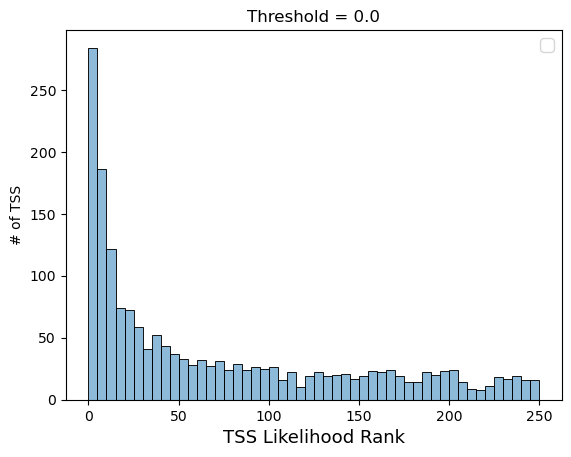

In [72]:
score_dict, fig = run_trial(prom_range_seq_new_df, Xy_raw_new_nowiggle, models_to_try)

## With wiggle room

In [65]:
# accounting for overlapping tsses in multiple tus. 

Xy_raw_new_overlap = Xy_raw_new.copy()

true_tss = list(Xy_raw_new[Xy_raw_new['label']==1]['loci'])

Xy_raw_new_overlap.loc[Xy_raw_new_overlap['loci'].isin(true_tss),'label']=1

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


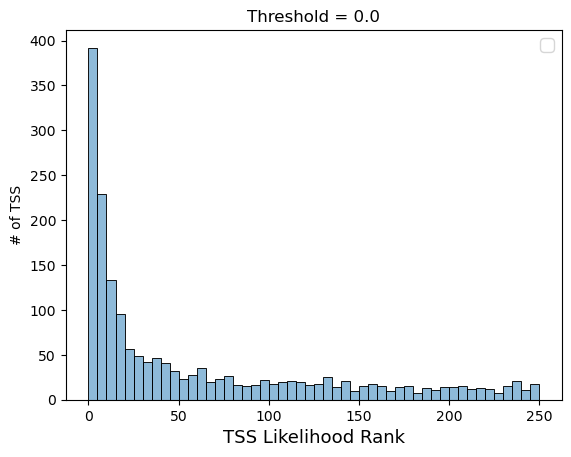

In [68]:
score_dict, fig = run_trial(prom_range_seq_new_df, Xy_raw_new_overlap, models_to_try)

# Notes

Search range for 10 and 35 boxes

What if the negative tss is actually giving the value of true tss because of the search range?

Are those negative tss real negative tss?


Some tss close to the real tss showing very similar score to the true tss

- should we not include those in the negative set? like a wiggle room for the training set


About prediction:

- if one of the true_tss is in prediction

- topk scores in similar places (also because of spacer_lenth range?)

# DNA curve

Throughts:

- Feature importance for each dataset.
- Select the most importent features using feature importance?

- Add dnacurve score for spacer for the most likely sigma factor.
- Using dna curve as a confirmation? Build two model and use the dna curve one to confirmed?
- PCA since there're more features?

- What to use? the four region?

## Plot the curve score for all genes.

0 is the left position and 250 is the right position

In [53]:
# the average curve score for 250 upstream of all gene

result = np.empty((prom_range_seq_df.shape[0], 3, 251))

for i, gene in prom_range_seq_df.iterrows():

    seq = mg1655.get_sequence(gene['left']-20, gene['right']+20, gene['strand'])
    curve = dnacurve.CurvedDNA(str(seq), 'aawedge').curvature[:, 20:-20]
    
    # curve is in shape (3, 251)--> concatenate to (#gene, 3, 251)
    result[i] = curve

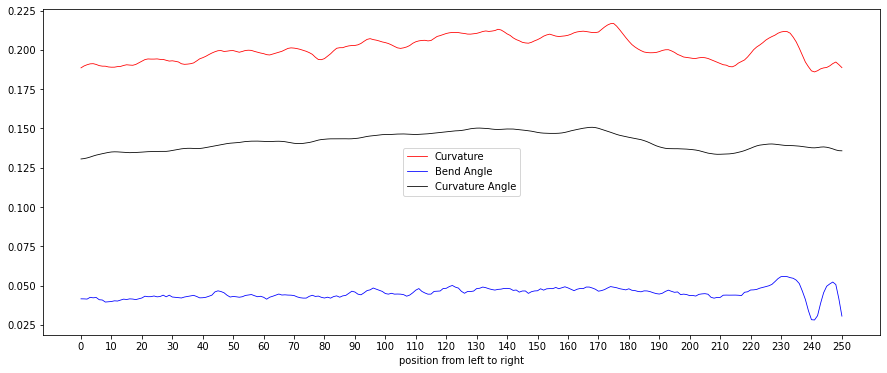

In [28]:
# plot curve profile for genes
_, ax = plt.subplots(figsize=(15,6))

ax.plot(
    np.arange(251),
    np.mean(result,axis=0)[0],
    'r-',
    lw=0.8
)

ax.plot(
    np.arange(251),
    np.mean(result,axis=0)[1],
    'b-',
    lw=0.8
)

ax.plot(
    np.arange(251),
    np.mean(result,axis=0)[2],
    'k-',
    lw=0.8,
)

ax.set_xlabel('position from left to right')
_ = plt.xticks(range(0,260,10))

ax.legend(['Curvature','Bend Angle','Curvature Angle'])


In [109]:
result = np.empty((1963, 3, 201))

#result = np.array([[[]]])
count = 0 
for i, gene in prom_range_seq_df.iterrows():
    
    tsses = gene['tsses']
    strand = gene['strand']
    
    for tss in tsses:
        
        if strand == 1:
            
            seq = mg1655.get_sequence(tss-200, tss+40, gene['strand'])
            curve = dnacurve.CurvedDNA(str(seq), 'aawedge').curvature[:, 20:-20]

            # curve is in shape (3, 251)--> concatenate to (#gene, 3, 251)
            result[count] = curve
            
        else:
            
            seq = mg1655.get_sequence(tss-40, tss+200, gene['strand'])
            curve = dnacurve.CurvedDNA(str(seq), 'aawedge').curvature[:, 20:-20]

            # curve is in shape (3, 251)--> concatenate to (#gene, 3, 251)
            result[count] = curve

#         curve = curve.reshape(1,3,201)
#         result = np.append(result,curve, axis=0)
        
        
        
        count+=1

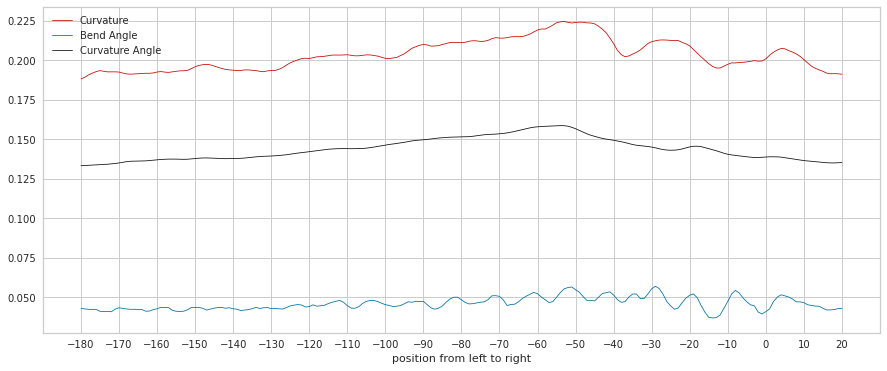

In [111]:
# plot curve profile for tsses
_, ax = plt.subplots(figsize=(15,6))

ax.plot(
    np.arange(-180,21),
    np.mean(result,axis=0)[0],
    'r-',
    lw=0.8
)

ax.plot(
    np.arange(-180,21),
    np.mean(result,axis=0)[1],
    'b-',
    lw=0.8
)

ax.plot(
    np.arange(-180,21),
    np.mean(result,axis=0)[2],
    'k-',
    lw=0.8,
)

ax.set_xlabel('position from left to right')
_ = plt.xticks(range(-180,30,10))

ax.legend(['Curvature','Bend Angle','Curvature Angle'])

In [94]:
count = 0
for i, row in prom_range_seq_df.iterrows():
    tss_count = len(row['tsses'])
    count += tss_count
    
print('There are %s TSS in total' % count)

There are 1963 TSS in total


In [112]:
result = np.empty((1963, 3, 451))
count = 0 
for i, gene in prom_range_seq_df.iterrows():
    
    tsses = gene['tsses']
    strand = gene['strand']
    
    for tss in tsses:
        
        if strand == 1:
            
            seq = mg1655.get_sequence(tss-320, tss+170, gene['strand'])
            curve = dnacurve.CurvedDNA(str(seq), 'aawedge').curvature[:, 20:-20]

            # curve is in shape (3, 251)--> concatenate to (#gene, 3, 251)
            result[count] = curve
            
        else:
            
            seq = mg1655.get_sequence(tss-170, tss+320, gene['strand'])
            curve = dnacurve.CurvedDNA(str(seq), 'aawedge').curvature[:, 20:-20]

            # curve is in shape (3, 251)--> concatenate to (#gene, 3, 251)
            result[count] = curve

        
        count+=1

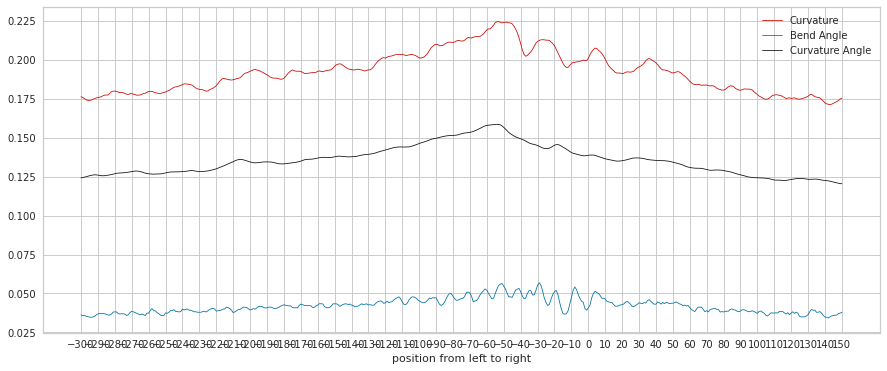

In [113]:
_, ax = plt.subplots(figsize=(15,6))

ax.plot(
    np.arange(-300,151),
    np.mean(result,axis=0)[0],
    'r-',
    lw=0.8
)

ax.plot(
    np.arange(-300,151),
    np.mean(result,axis=0)[1],
    'b-',
    lw=0.8
)

ax.plot(
    np.arange(-300,151),
    np.mean(result,axis=0)[2],
    'k-',
    lw=0.8,
)

ax.set_xlabel('position from left to right')
_ = plt.xticks(range(-300,160,10))

ax.legend(['Curvature','Bend Angle','Curvature Angle'])

In [49]:
# <TO-DO> plot all the curvature value for positives and negatives.

# Performance by subsets of features

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


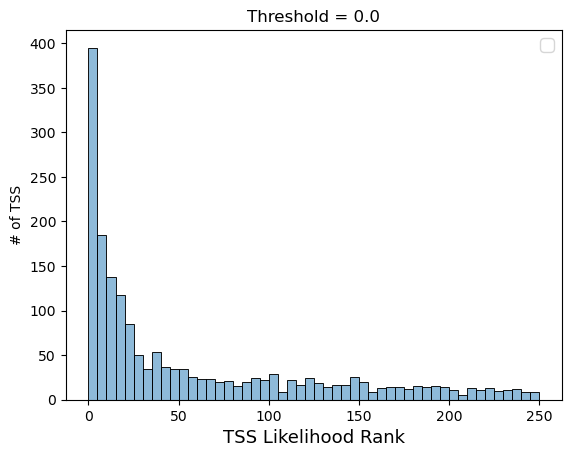

In [74]:
score_dict, fig = run_trial(prom_range_seq_new_df, Xy_raw_new_overlap, models_to_try, features=[motif])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


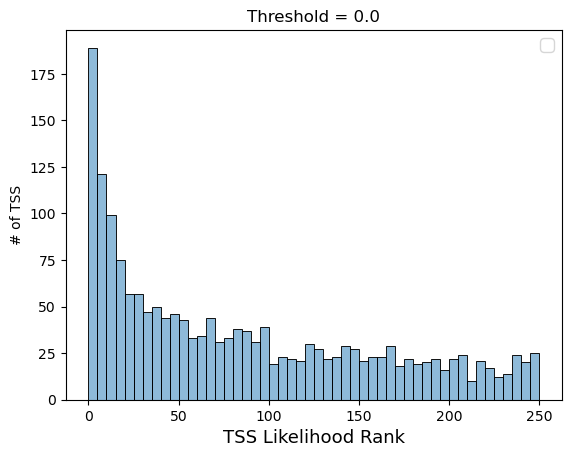

In [75]:
score_dict, fig = run_trial(prom_range_seq_new_df, Xy_raw_new_overlap, models_to_try, features=[shape])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


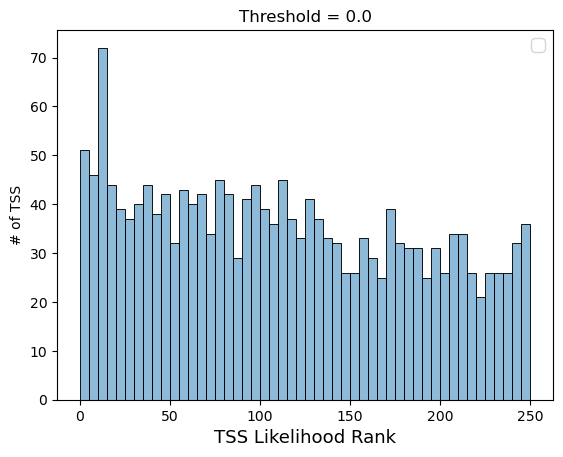

In [76]:
score_dict, fig = run_trial(prom_range_seq_new_df, Xy_raw_new_overlap, models_to_try, features=[curve])

# W3110 raw data

In [13]:
# load bitome

genome_dir = Path('..', 'data', 'e_coli_genomes', 'refseq')
w3110 = Bitome(Path(genome_dir, 'Ecoli_W3110.gb'), name='W3110')

# load raw data
df_wt = pd.read_csv('../data/TSS_raw_W3110_v2.csv')
df_min = pd.read_csv('../data/TSS_raw_minE_v2.csv')


df_wt = df_wt.rename({'ID':'name', 'Strand':'strand', 'Position':'tss', 'Type':'type'},axis=1)
df_wt = df_wt.replace({'+':1, '-':-1})

## Prepare blast for mg1655 genes

In [14]:
# prepare mg1655 tu fasta

BLAST_PATH = Path('../data/tu_featurized_sweep/')
with open(Path(BLAST_PATH, 'mg1655_gene_250.fasta'), 'w') as file_out:
    
    # modified from multistrain notebook with including tus that don't have a tss
#     clean_tu_table = mg1655.tu_table[(mg1655.tu_table['left'].notna()) & (mg1655.tu_table['right'].notna()) & 
#                                     (mg1655.tu_table['strand'].notna())]
    
    
    for tu_row in mg1655.gene_table.itertuples():
        tu_seq = str(mg1655.get_sequence(tu_row.left, tu_row.right, tu_row.strand))
        file_out.write(f'>{tu_row.Index}\n{tu_seq}\n')

## BLAST for MG1655 genes

In [15]:
import subprocess
column_names = [
    'mg_gene', 'strain_id', 'percent', 'align_length', 'n_mismatch', 'n_gapopen',
    'mg_start', 'mg_end', 'strain_start', 'strain_end', 'e_value', 'bit_score'
]


id_to_name = {
    'NC_004431.1': 'CFT073','NC_017626.1': '042','NC_007779.1': 'W3110',
    'NC_002695.1': 'O157:H7','NC_010468.1': 'Crooks','NC_017660.1': 'KO11FL',
    'NC_012971.2': 'BL21','NC_017635.1': 'W'
}

genome_dir = Path('..', 'data', 'e_coli_genomes', 'refseq')
bitomes_by_id = {'NC_007779.1': Bitome(Path(genome_dir, 'Ecoli_W3110.gb'))}

for strain_id, bitome in bitomes_by_id.items():
    
    if strain_id == 'NC_007779.1':
    
        # run the blast query
        subprocess.check_output(['blastn',
                             '-db', Path('../data/multi_strain_blast/', strain_id),
                             '-query', Path(BLAST_PATH, 'mg1655_gene_250.fasta'),
                             '-out', Path(BLAST_PATH, f'{strain_id}.csv'),
                             '-evalue', '0.001',
                             '-outfmt', '10',
                             '-num_threads', '4'])

In [16]:
multi_strain_tu_rows = []

for strain_id, bitome in bitomes_by_id.items():
    
    # read in the file, add column names
    blast_report_df = pd.read_csv(Path(BLAST_PATH, f'{strain_id}.csv'), header=0, names=column_names)
    
    # move through and only keep the best match by TU
    for gene, tu_blast_df in blast_report_df.groupby('mg_gene'):
        
        mg_gene_name = mg1655.gene_table.loc[gene, 'name']
        mg_upstream_left = mg1655.gene_table.loc[gene, 'left']
        mg_upstream_right = mg1655.gene_table.loc[gene, 'right']
     
        matches_from_start = tu_blast_df[(tu_blast_df['n_mismatch']<10) | (tu_blast_df['mg_end'] > 200 ) ]
       
        matches_from_start = matches_from_start.sort_values(by='mg_end', ascending=False)
        #print(matches_from_start)
        
        if not matches_from_start.empty:
            strain_start, strain_end = matches_from_start.iloc[0, :][['strain_start', 'strain_end']].values
            if strain_start < strain_end:
#                 strain_tss = strain_start
                strain_strand = 1
                length = strain_end - strain_start
                strain_left = strain_start
                strain_right = strain_end
            else:
#                 strain_tss = strain_end
                strain_strand = -1
                length = strain_start - strain_end
                strain_left = strain_end
                strain_right = strain_start
            
            tu_match_row = [matches_from_start.iloc[0, :]['mg_gene'], mg_gene_name, 
                            int(mg1655.gene_table.loc[gene, 'strand']), mg_upstream_left, mg_upstream_right,
                           strain_strand, strain_left, strain_right, length ]
            multi_strain_tu_rows.append(tu_match_row)
    
multi_strain_tu_df = pd.DataFrame(multi_strain_tu_rows, 
                                  columns=['mg_gene_id', 'mg_gene_name', 'mg_strand', 'mg_upstream_left', 'mg_upstream_right',
                                           'strain_strand', 'strain_upstream_left', 'strain_upstream_right',
                                           'strain_upstream_length'])

## Add name to W3110 genes based on mapping to mg1655 

In [17]:
w3110_gene_df = w3110.gene_table
for gene_locus, row in w3110_gene_df.iterrows():
    if row['strand'] == 1:
        gene = multi_strain_tu_df[(multi_strain_tu_df['strain_strand'] == 1) & 
        (multi_strain_tu_df['strain_upstream_left'] == row['left'])]
        
        
    else:
        gene = multi_strain_tu_df[(multi_strain_tu_df['strain_strand'] == -1) & 
                           (multi_strain_tu_df['strain_upstream_right']==row['right'] ) ] 
    if not gene.empty:
        w3110_gene_df.loc[gene_locus, 'gene_id'] = gene['mg_gene_id'].iloc[0]
        w3110_gene_df.loc[gene_locus, 'name'] = gene['mg_gene_name'].iloc[0]

In [18]:
w3110.gene_table = w3110_gene_df

## Map raw tsses to their nearest gene

In [19]:
def raw_tss_map(raw_tss_table, ref_tu_table):
    mapped_tss_table = raw_tss_table.copy()
    for i, row in raw_tss_table.iterrows():
        tss_raw = row['tss']
        tu_strand = ref_tu_table[ref_tu_table['strand']==row['strand']].copy()

        if row['strand']==1:
            temp_dist = tu_strand['left'] - tss_raw

        else:
            temp_dist = tss_raw - tu_strand['right']

        if [i for i in (temp_dist) if i >= 0] == []:
            continue


        min_dist = min( [i for i in (temp_dist) if i >= 0])
        locus_tag = tu_strand.index[np.where(temp_dist==min_dist)[0][0]]    
        
        mapped_tss_table.loc[i, 'locus'] = locus_tag
        mapped_tss_table.loc[i, 'mapped_id'] = tu_strand.loc[locus_tag, 'gene_id']
        mapped_tss_table.loc[i, 'mapped_gene'] = tu_strand.loc[locus_tag, 'name']
        mapped_tss_table.loc[i, 'tss_to_gene'] = min_dist
        mapped_tss_table.loc[i, 'left'] = tu_strand.loc[locus_tag, 'left']
        mapped_tss_table.loc[i, 'right'] = tu_strand.loc[locus_tag, 'right']
        
    return mapped_tss_table

In [168]:
df_wt_normal = df_wt[df_wt['type']=='normal'].copy()
df_wt_normal_mapped = raw_tss_map(df_wt_normal, w3110.gene_table)

# df_wt_normal_mapped['Compare'] = df_wt_normal_mapped.apply(lambda x: 'Yes' if x['Annotation'] in x['mapped_tu/gene'] else 'No',axis=1)

In [21]:
close = df_wt_normal_mapped[df_wt_normal_mapped['tss_to_gene']<=300].copy()
#close[close['Compare']=='No'].shape
close.shape

(425, 17)

In [22]:
too_far = df_wt_normal_mapped[df_wt_normal_mapped['tss_to_gene']>300].copy()
#too_far[too_far['Compare']=='Yes'].shape
too_far.shape

(9, 17)

In [23]:
df_wt_normal_mapped.fillna(value='no name', inplace=True)

In [24]:
df_wt_normal_mapped['compare'] = df_wt_normal_mapped.apply(lambda x: x["mapped_gene"] in x["Annotation"], axis=1)

df_wt_normal_mapped[df_wt_normal_mapped['compare']==False]

,name,tss,strand,type,Annotation,Ctrl1,Ctrl2,Ctrl3,TAP1,TAP2,TAP3,locus,mapped_id,mapped_gene,tss_to_gene,left,right,compare
54,TSS_W3110_55,189552,1,normal,tff,51.7,48.6,71.3,92.8,70.6,175.5,Y75_RS00855,b0169,rpsB,322.0,189874.0,190599.0,False
56,TSS_W3110_57,189760,-1,normal,map,33.1,5.9,6.4,34.6,2.8,9.3,Y75_RS23070,no name,no name,33.0,189506.0,189727.0,False
94,TSS_W3110_95,319257,1,normal,ykgD,2.2,17.7,4.5,7.5,31.2,18.8,Y75_RS01580,b0305,rclR,194.0,319451.0,320305.0,False
114,TSS_W3110_115,453575,-1,normal,yajG,2.4,5.8,3.8,10.0,8.7,24.1,Y75_RS23200,no name,no name,3.0,453441.0,453572.0,False
115,TSS_W3110_116,453658,-1,normal,yajG,3.6,4.8,2.5,10.6,10.1,21.2,Y75_RS23200,no name,no name,86.0,453441.0,453572.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1520,TSS_W3110_1521,3478223,1,normal,oxyS,3.3,1.1,1.8,33.5,7.0,13.9,Y75_RS17305,b3957,argE,3611.0,3481834.0,3482985.0,False
1529,TSS_W3110_1530,3585888,-1,normal,csrC,9.6,10.3,12.7,27.7,15.6,44.3,Y75_RS17795,b3866,yihI,554.0,3584825.0,3585334.0,False
1545,TSS_W3110_1546,4000416,1,normal,yhiO,40.5,22.4,21.4,31.3,15.1,28.3,Y75_RS19790,b3494,uspB,279.0,4000695.0,4001030.0,False
1546,TSS_W3110_1547,4042692,-1,normal,yhhK,45.0,12.8,14.3,66.8,17.1,34.5,Y75_RS19980,b3459,panM,261.0,4042048.0,4042431.0,False


Four different types of tss, build different models for them.

In [177]:
df_wt['type'].value_counts()

antisense    562
orphan       531
normal       434
internal      45
Name: type, dtype: int64

## Examine orphan tsses

In [173]:
df_wt_orphan = df_wt[df_wt['type']=='orphan'].copy()
df_wt_orphan_mapped = raw_tss_map(df_wt_orphan, w3110.gene_table)

df_wt_orphan_mapped[df_wt_orphan_mapped['tss_to_gene']<300].shape

(25, 17)

Some of the orphan tsses are mapped to unknown genes in w3110

<AxesSubplot:xlabel='tss_to_gene', ylabel='Count'>

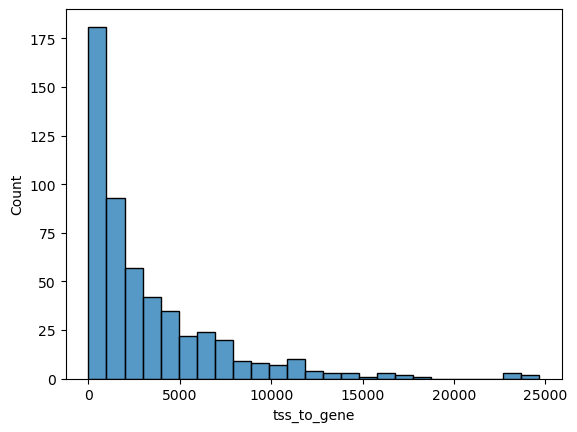

In [171]:
sns.histplot(df_wt_orphan_mapped['tss_to_gene'])

## Examine internal tsses

In [186]:
df_wt_internal = df_wt[df_wt['type']=='internal'].copy()
df_wt_internal_mapped = raw_tss_map(df_wt_internal, w3110.gene_table)

df_wt_internal_mapped[df_wt_internal_mapped['tss_to_gene']<300].shape

(5, 17)

## Creat sweep dataset for W3100 raw data (normal)

Questions:
- How do we analyze feature importance with sweep? Train on all data(after undersampling)? Only on the tus that have their true tss ranked high?
- How do we incooperate the expression data into the dataset. The best way maybe to use them as type seperation, as the negative samples don't have expression data.

In [49]:
def create_sweep_dataset_raw(tu_table, n_upstream=250, n_downstream=25, bitome_obj=mg1655):
    
    # get the TU info where we have high-confidence TSS annotation
    
    
    sequence_rows = []
    label_rows = []

    # for each TU with a TSS, get the closest gene start
    for i, tu_row in tu_table.iterrows():

        if pd.isnull(tu_row['tss']) | (tu_row['tss_to_gene']>n_upstream):
            continue
            
        if tu_row['strand'] == 1:
            gene_start = tu_row['left']
        else:
            gene_start = tu_row['right']
        
        # determine the left/right ends of our range based on strand
        if tu_row['strand'] == 1:
            left, right = gene_start - n_upstream, gene_start + n_downstream
        else:
            left, right = gene_start - n_downstream, gene_start + n_upstream
            

        # combine the tus that has multiple tsses
        same_left = tu_table[tu_table['left'] == tu_row['left']]
        same_right_left = same_left[same_left['right'] == tu_row['right']]
        
        if same_right_left['tss'].shape[0]>1:
            not_self = same_right_left[same_right_left['tss']!=tu_row['tss']]
            tsses = sum([list(not_self['tss']), [tu_row['tss']]], [])
        
        else: 
            tsses = [tu_row['tss']]
        
        
        same_tu = tu_table[tu_table['locus']==tu_row['locus']]
        
        prom_range_sequence = bitome_obj.get_sequence(left, right, tu_row['strand'])
        # we actually want to "start" (i.e. have the model's first time step) be at the gene itself
        # so we have to flip this sequence here
        prom_range_sequence = prom_range_sequence[::-1]
        
        
        # now let's set up the label vector; this should match the REVERSED order of the sequence
        # i.e. should start downstream and go upstream; this means we only have to reverse for the 
        # forward strand, because left to right IS down to upstream on -1 strand
        prom_range_poses = np.arange(left, right + 1)
        if tu_row['strand'] == 1:
            prom_range_poses = np.flip(prom_range_poses)
        label_vector = np.zeros(prom_range_poses.shape)

        label_vector[np.argwhere(prom_range_poses == tu_row['tss'])] = 1

        # now let's add to our running list of data info and labels
        sequence_rows.append({
            'gene': tu_row['locus'],
            'left': int(left),
            'right': int(right),
            'strand': tu_row['strand'],
            'seq': str(prom_range_sequence),
            'tsses': list(tsses),
            'mapped_id': tu_row['mapped_id']
        })
        
        label_rows.append(label_vector)

    prom_range_seq_df = pd.DataFrame(sequence_rows)
    label_cols = np.flip(np.arange(-n_upstream, n_downstream + 1))
    label_df = pd.DataFrame(
        label_rows,
        index=prom_range_seq_df['gene'],
        columns=label_cols,
        dtype=int
    )
    
    label_df = label_df.iloc[prom_range_seq_df.drop_duplicates(subset=['seq', 'left', 'right','strand']).index, :]
    
    prom_range_seq_df.drop_duplicates(subset=['seq', 'left', 'right','strand'], inplace=True, ignore_index=True)
    
    # create an ML-ready data array for just the one-hot encoded sequences
    prom_range_data_array = create_data_array(prom_range_seq_df)
    
    
    return prom_range_seq_df, prom_range_data_array, label_df

In [50]:
prom_range_seq_raw_df, prom_range_data_array, label_df = create_sweep_dataset_raw(tu_table = df_wt_normal_mapped, 
                                                                              n_upstream=300, n_downstream=0,
                                                                             bitome_obj = w3110)

In [188]:
prom_dict = {'raw_df': prom_range_seq_raw_df, 'data_array': prom_range_data_array, 
             'label_df': label_df}

In [190]:
import pickle
with open('../data/tu_featurized_sweep/prom_seq_w3110_raw.pickle', 'wb') as handle:
    pickle.dump(prom_dict, handle)

In [27]:
Xy_raw_normal, time = create_Xy(prom_range_seq_df, bitome_obj=w3110, wiggle_room=2)

0
300
600
900
1200
1500
1800
2100
2400
2700
3000
3300
3600
3900
4200
4500
4800
5100
5400
5700
6000
6300
6600
6900
7200
7500
7800
8100
8400
8700
9000
9300
9600
9900
10200
10500
10800
11100
11400
11700
12000
12300
12600
12900
13200
13500
13800
14100
14400
14700
15000
15300
15600
15900
16200
16500
16800
17100
17400
17700
18000
18300
18600
18900
19200
19500
19800
20100
20400
20700
21000
21300
21600
21900
22200
22500
22800
23100
23400
23700
24000
24300
24600
24900
25200
25500
25800
26100
26400
26700
27000
27300
27600
27900
28200
28500
28800
29100
29400
29700
30000
30300
30600
30900
31200
31500
31800
32100
32400
32700
33000
33300
33600
33900
34200
34500
34800
35100
35400
35700
36000
36300
36600
36900
37200
37500
37800
38100
38400
38700
39000
39300
39600
39900
40200
40500
40800
41100
41400
41700
42000
42300
42600
42900
43200
43500
43800
44100
44400
44700
45000
45300
45600
45900
46200
46500
46800
47100
47400
47700
48000
48300
48600
48900
49200
49500
49800
50100
50400
50700
51000
51300
51600
51

In [28]:
Xy_raw_normal.to_csv('../data/tu_featurized_sweep/featurized_w3110raw_normal_sweep.csv')

# Compare mg1655 and raw W3110 motif score

Text(0.5, 0.98, 'Motif Scores for True TSS')

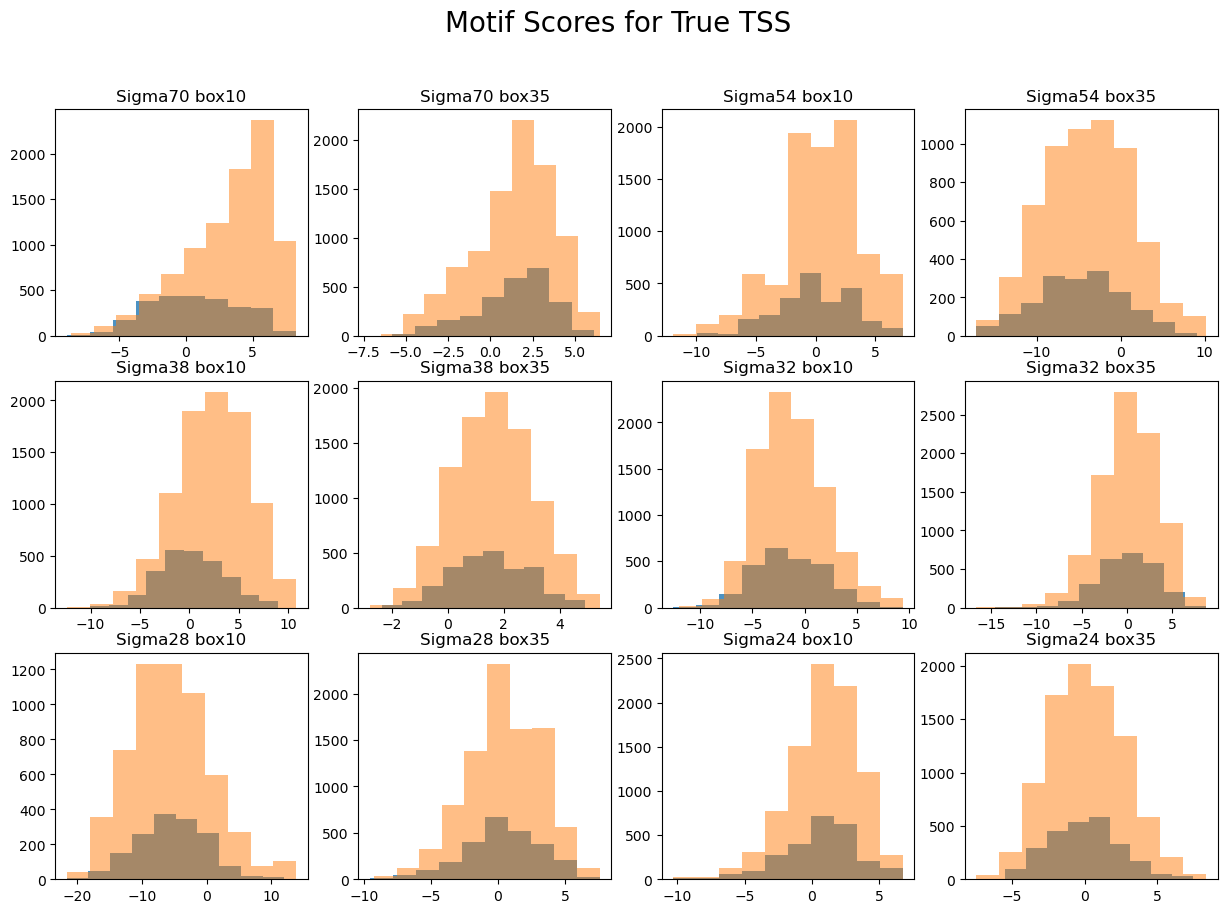

In [200]:
# motif score

True_tss = Xy_raw_normal_overlap[Xy_raw_normal_overlap['label']==1]
False_tss = Xy_raw_normal_overlap[Xy_raw_normal_overlap['label']==0]

True_tss_mg = Xy_raw[Xy_raw['label']==1]
False_tss_mg = Xy_raw[Xy_raw['label']==0]

fig, axes = plt.subplots(3,4, figsize=(15,10))

axes[0,0].hist(True_tss['box_10_70'],alpha=0.8)
axes[0,0].hist(True_tss_mg['box_10_70'],alpha=0.5)
axes[0,0].set_title('Sigma70 box10')


axes[0,1].hist(True_tss['box_35_70'],alpha=0.8)
axes[0,1].hist(True_tss_mg['box_35_70'],alpha=0.5)
axes[0,1].set_title('Sigma70 box35')

axes[0,2].hist(True_tss[True_tss['box_10_54']!=-1000000]['box_10_54'],alpha=0.8)
axes[0,2].hist(True_tss_mg[True_tss_mg['box_10_54']!=-1000000]['box_10_54'],alpha=0.5)
axes[0,2].set_title('Sigma54 box10')
#axes[0,2].set_xlim([-1,0])


axes[0,3].hist(True_tss[True_tss['box_35_54']!=-1000000]['box_35_54'],alpha=0.8)
axes[0,3].hist(True_tss_mg[True_tss_mg['box_35_54']!=-1000000]['box_35_54'],alpha=0.5)
axes[0,3].set_title('Sigma54 box35')

axes[1,0].hist(True_tss[True_tss['box_10_38']!=-1000000]['box_10_38'],alpha=0.8)
axes[1,0].hist(True_tss_mg[True_tss_mg['box_10_38']!=-1000000]['box_10_38'],alpha=0.5)
axes[1,0].set_title('Sigma38 box10')

axes[1,1].hist(True_tss['box_35_38'],alpha=0.8)
axes[1,1].hist(True_tss_mg['box_35_38'],alpha=0.5)
axes[1,1].set_title('Sigma38 box35')

axes[1,2].hist(True_tss[True_tss['box_10_32']!=-1000000]['box_10_32'],alpha=0.8)
axes[1,2].hist(True_tss_mg[True_tss_mg['box_10_32']!=-1000000]['box_10_32'],alpha=0.5)
axes[1,2].set_title('Sigma32 box10')

axes[1,3].hist(True_tss[True_tss['box_35_32']!=-1000000]['box_35_32'],alpha=0.8)
axes[1,3].hist(True_tss_mg[True_tss_mg['box_35_32']!=-1000000]['box_35_32'],alpha=0.5)
axes[1,3].set_title('Sigma32 box35')

axes[2,0].hist(True_tss[True_tss['box_10_28']!=-1000000]['box_10_28'],alpha=0.8)
axes[2,0].hist(True_tss_mg[True_tss_mg['box_10_28']!=-1000000]['box_10_28'],alpha=0.5)
axes[2,0].set_title('Sigma28 box10')

axes[2,1].hist(True_tss[True_tss['box_35_28']!=-1000000]['box_35_28'], alpha=0.8)
axes[2,1].hist(True_tss_mg[True_tss_mg['box_35_28']!=-1000000]['box_35_28'], alpha=0.5)
axes[2,1].set_title('Sigma28 box35')
#axes[2,1].set_xlim([-20,10])

axes[2,2].hist(True_tss[True_tss['box_10_24']!=-1000000]['box_10_24'], alpha=0.8)
axes[2,2].hist(True_tss_mg[True_tss_mg['box_10_24']!=-1000000]['box_10_24'], alpha=0.5)
axes[2,2].set_title('Sigma24 box10')
#axes[2,2].set_xlim([-20,10])

axes[2,3].hist(True_tss[True_tss['box_35_24']!=-1000000]['box_35_24'], alpha=0.8)
axes[2,3].hist(True_tss_mg[True_tss_mg['box_35_24']!=-1000000]['box_35_24'], alpha=0.5)
axes[2,3].set_title('Sigma24 box35')

fig.suptitle('Motif Scores for True TSS', fontsize=(20))

Text(0.5, 0.98, 'Motif Scores for False TSS')

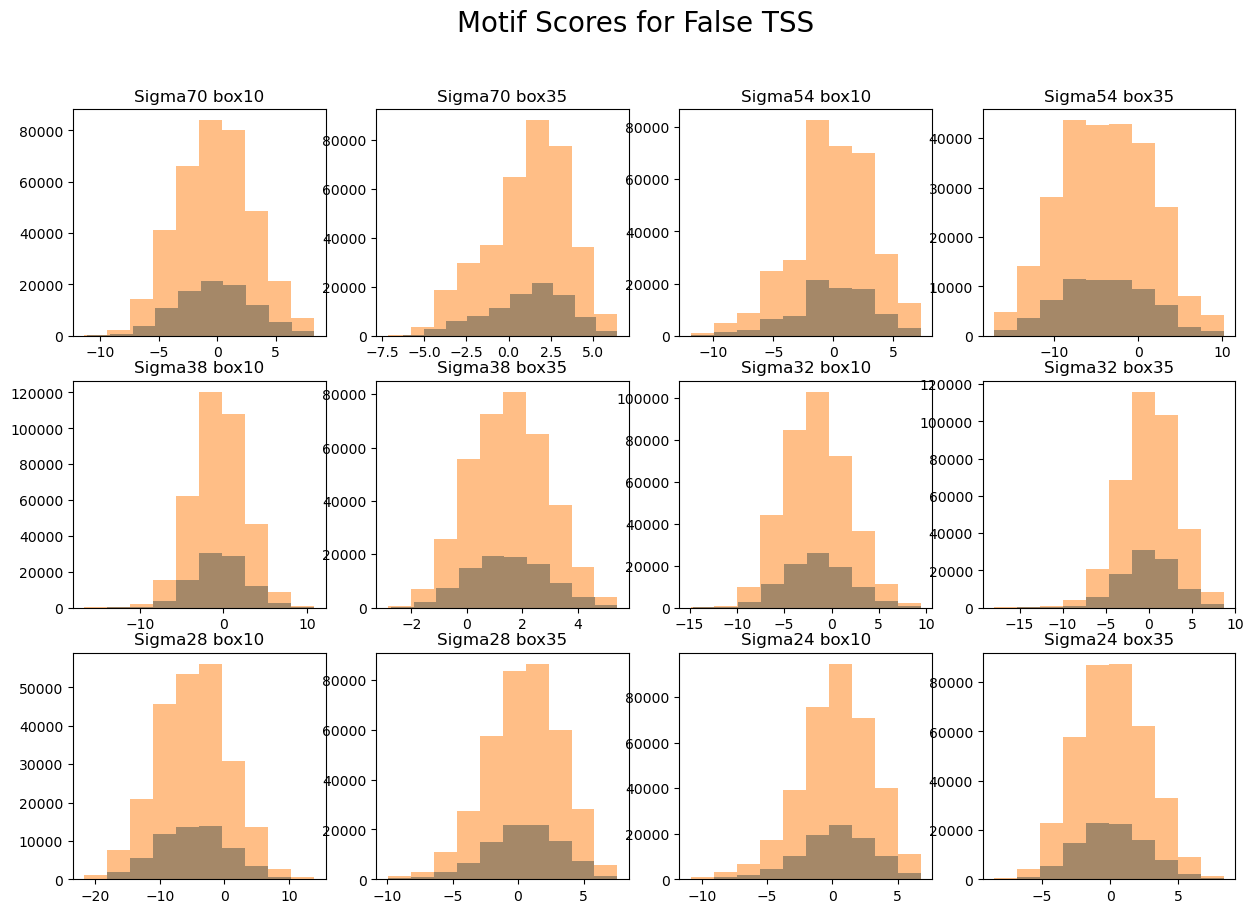

In [202]:
fig, axes = plt.subplots(3,4, figsize=(15,10))
axes[0,0].hist(False_tss['box_10_70'],alpha=0.8)
axes[0,0].hist(False_tss_mg['box_10_70'],alpha=0.5)
axes[0,0].set_title('Sigma70 box10')


axes[0,1].hist(False_tss['box_35_70'],alpha=0.8)
axes[0,1].hist(False_tss_mg['box_35_70'],alpha=0.5)
axes[0,1].set_title('Sigma70 box35')

axes[0,2].hist(False_tss[False_tss['box_10_54']!=-1000000]['box_10_54'],alpha=0.8)
axes[0,2].hist(False_tss_mg[False_tss_mg['box_10_54']!=-1000000]['box_10_54'],alpha=0.5)
axes[0,2].set_title('Sigma54 box10')
#axes[0,2].set_xlim([-1,0])


axes[0,3].hist(False_tss[False_tss['box_35_54']!=-1000000]['box_35_54'],alpha=0.8)
axes[0,3].hist(False_tss_mg[False_tss_mg['box_35_54']!=-1000000]['box_35_54'],alpha=0.5)
axes[0,3].set_title('Sigma54 box35')

axes[1,0].hist(False_tss[False_tss['box_10_38']!=-1000000]['box_10_38'],alpha=0.8)
axes[1,0].hist(False_tss_mg[False_tss_mg['box_10_38']!=-1000000]['box_10_38'],alpha=0.5)
axes[1,0].set_title('Sigma38 box10')

axes[1,1].hist(False_tss['box_35_38'],alpha=0.8)
axes[1,1].hist(False_tss_mg['box_35_38'],alpha=0.5)
axes[1,1].set_title('Sigma38 box35')

axes[1,2].hist(False_tss[False_tss['box_10_32']!=-1000000]['box_10_32'],alpha=0.8)
axes[1,2].hist(False_tss_mg[False_tss_mg['box_10_32']!=-1000000]['box_10_32'],alpha=0.5)
axes[1,2].set_title('Sigma32 box10')

axes[1,3].hist(False_tss[False_tss['box_35_32']!=-1000000]['box_35_32'],alpha=0.8)
axes[1,3].hist(False_tss_mg[False_tss_mg['box_35_32']!=-1000000]['box_35_32'],alpha=0.5)
axes[1,3].set_title('Sigma32 box35')

axes[2,0].hist(False_tss[False_tss['box_10_28']!=-1000000]['box_10_28'],alpha=0.8)
axes[2,0].hist(False_tss_mg[False_tss_mg['box_10_28']!=-1000000]['box_10_28'],alpha=0.5)
axes[2,0].set_title('Sigma28 box10')

axes[2,1].hist(False_tss[False_tss['box_35_28']!=-1000000]['box_35_28'], alpha=0.8)
axes[2,1].hist(False_tss_mg[False_tss_mg['box_35_28']!=-1000000]['box_35_28'], alpha=0.5)
axes[2,1].set_title('Sigma28 box35')
#axes[2,1].set_xlim([-20,10])

axes[2,2].hist(False_tss[False_tss['box_10_24']!=-1000000]['box_10_24'], alpha=0.8)
axes[2,2].hist(False_tss_mg[False_tss_mg['box_10_24']!=-1000000]['box_10_24'], alpha=0.5)
axes[2,2].set_title('Sigma24 box10')
#axes[2,2].set_xlim([-20,10])

axes[2,3].hist(False_tss[False_tss['box_35_24']!=-1000000]['box_35_24'], alpha=0.8)
axes[2,3].hist(False_tss_mg[False_tss_mg['box_35_24']!=-1000000]['box_35_24'], alpha=0.5)
axes[2,3].set_title('Sigma24 box35')

fig.suptitle('Motif Scores for False TSS', fontsize=(20))

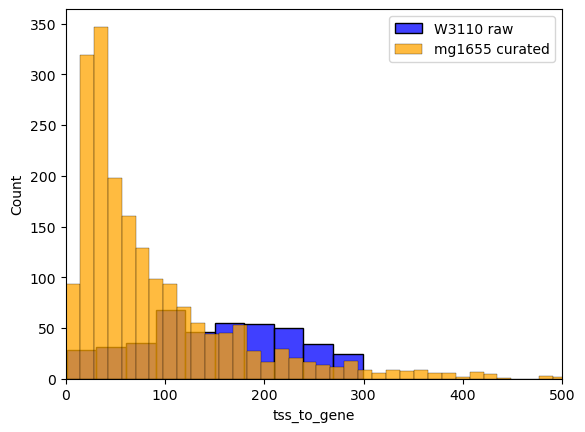

In [167]:
# distance to gene

#mg1655
tsses_to_tu_list = []
for i, row in prom_range_seq_df.iterrows(): 
    
    if prom_range_seq_df.loc[i, 'strand']==1:
        tsses_to_tu = prom_range_seq_df.loc[i,'right'] - prom_range_seq_df.loc[i,'tsses']
        
    else:
        tsses_to_tu = abs(prom_range_seq_df.loc[i,'left'] - prom_range_seq_df.loc[i,'tsses'])

    tsses_to_tu_list = np.concatenate([tsses_to_tu_list,tsses_to_tu],axis=0)


ax = sns.histplot(df_wt_normal_mapped[df_wt_normal_mapped['tss_to_gene']<300]['tss_to_gene'],color="b",label='W3110 raw')
ax = sns.histplot(tsses_to_tu_list,color='orange', label='mg1655 curated')
ax.set(xlim=(0,500))
ax.legend()

# Run ML for raw data

In [31]:
Xy_raw_normal = pd.read_csv('../data/tu_featurized_sweep/featurized_w3110raw_normal_sweep.csv',index_col=0)

In [46]:
# accounting for overlapping tsses in multiple tus. 

Xy_raw_normal_overlap = Xy_raw_normal.copy()

true_tss = list(Xy_raw_normal[Xy_raw_normal['label']==1]['loci'])

Xy_raw_normal_overlap.loc[Xy_raw_new_overlap['loci'].isin(true_tss),'label']=1

In [35]:
models_to_try = {
#     'LR': LogisticRegression(),
#     'SVM': SVC(),
    'RF': RandomForestClassifier(n_jobs=4),
}

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


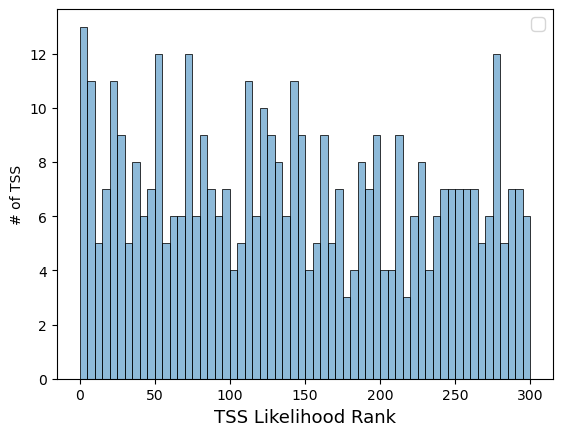

In [41]:
score_dict, fig = run_trial(prom_range_seq_df, Xy_raw_normal_overlap, models_to_try, val_fold = 5, features=[motif])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


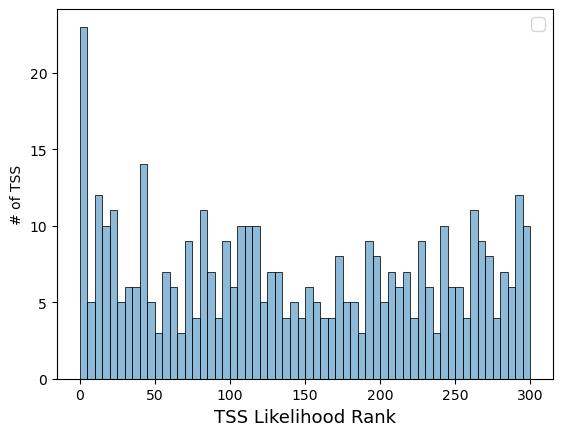

In [42]:
score_dict, fig = run_trial(prom_range_seq_df, Xy_raw_normal_overlap, models_to_try, val_fold = 5, features=[curve])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


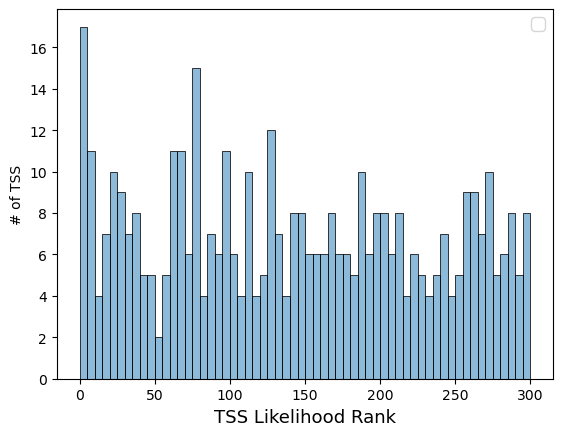

In [43]:
score_dict, fig = run_trial(prom_range_seq_df, Xy_raw_normal_overlap, models_to_try, val_fold = 5, features=[shape])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


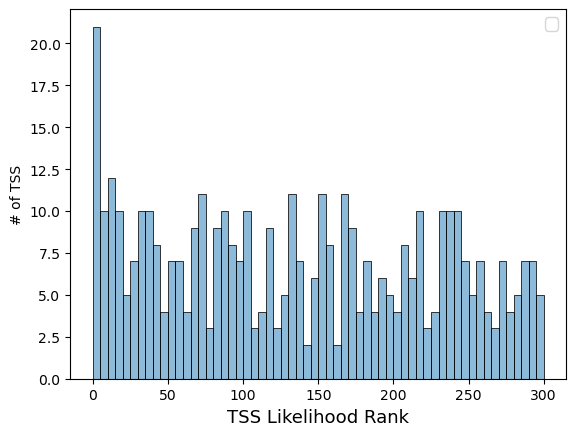

In [44]:
score_dict, fig = run_trial(prom_range_seq_df, Xy_raw_normal_overlap, models_to_try, val_fold = 5, features=[motif, shape, curve])

## Use mg1655 promoters as training set

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


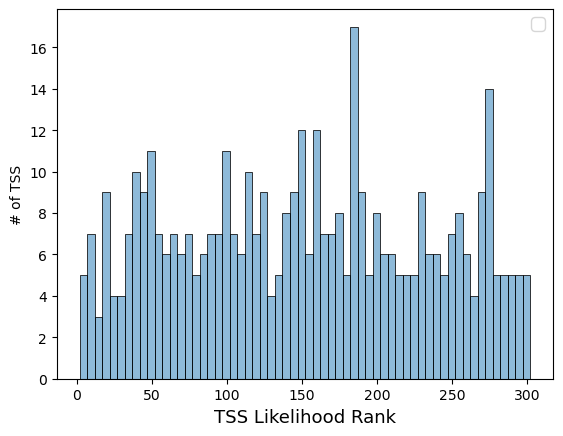

In [68]:
Xy_train = Xy_raw_new_overlap
Xy_val = Xy_raw_normal_overlap
model_list = models_to_try

train_gene_df = prom_range_seq_df
val_gene_df = prom_range_seq_raw_df

features = [motif, shape, curve]
    
    

features = sum(features,[])
    
    
pd.options.mode.chained_assignment=None
    
ranks = []

ranks_wiggle = []
    
for model_name in model_list:

    model = model_list[model_name]

    score_dict = {}
    correct_percent_all = []


    Xy_train[Xy_train==-inf] == -1000000


    # train the same way
    X_train, y_train = Xy_train.loc[:, Xy_train.columns.isin(features)], Xy_train.loc[:, 'label']

    
    model.fit(X_train, y_train)

    #Costume scoring function

    # scores could be confusion matrix stuff, or just yes/no by gene, or whatever
    result_dict, predicts = sweep_score_model(model, Xy_val, val_gene_df, features)

    ranks.extend(result_dict['tss_prob_rank'])

    ranks_wiggle.extend(result_dict['tss_wiggle_prob_rank'])

    val_scores = result_dict['predict_correctness']
    counts = Counter(val_scores)

    correct_percent = counts[1]/(len(val_scores))

    correct_percent_all.append(correct_percent)

    ranks = sum(ranks,[])
    ranks_wiggle = sum(ranks_wiggle, [])

    score_dict[model_name] = {'correct_percentage': np.mean(correct_percent_all),
                              'tss_prob_rank': ranks,
                              'tss_wiggle_prob_rank': ranks_wiggle
                             }


    fig, ax = plt.subplots()

    sns.histplot(ranks, binwidth=5, alpha=0.5, ax=ax)
    ax.legend(fontsize=12)
    ax.set_xlabel('TSS Likelihood Rank', fontsize=13)
    ax.set_ylabel('# of TSS')

Notes:
- add box_10 to tss distance
- examine the distance of box_10 to tss

- The raw data could have different motifs


# Creat CNN featurized dataset

In [597]:
def stack_prom_seq(prom_range_seq_df, featurized_prom_seq_df):

    label_rows = [] 
    
    data_array = np.empty((prom_range_seq_df.shape[0], len(prom_range_seq_df.loc[0, 'seq'])-1, 
                           featurized_prom_seq_df.drop(['label','loci','gene','strand'], axis=1).shape[1]))
    
    i=0
    for gene, prom_seq_df in featurized_prom_seq_df.groupby(by='gene'):

        features = prom_seq_df.drop(['label','loci','gene','strand'], axis=1) 
        
        data_array[i] = features
        
        # now let's set up the label vector; this should match the REVERSED order of the sequence
        # i.e. should start downstream and go upstream; this means we only have to reverse for the 
        # forward strand, because left to right IS down to upstream on -1 strand
        
        left = prom_range_seq_df[prom_range_seq_df['gene']==gene]['left'].iloc[0]
        right = prom_range_seq_df[prom_range_seq_df['gene']==gene]['right'].iloc[0]
        
        prom_range_poses = np.arange(left, right)
        if prom_range_seq_df[prom_range_seq_df['gene']==gene]['strand'].iloc[0] == 1:
            features = features.sort_index(ascending=False)
            prom_range_poses = np.flip(prom_range_poses)
            
        label_vector = np.zeros(prom_range_poses.shape)
        
        for tss in prom_range_seq_df[prom_range_seq_df['gene']==gene]['tsses'].iloc[0]:
            
            label_vector[np.argwhere(prom_range_poses == tss)] = 1
        
        label_rows.append(label_vector)
        
        
        seq_len = len(prom_range_seq_df['seq'].iloc[0])
        label_cols = np.flip(np.arange(-(seq_len-1), 0))
        
        i+=1

    label_df = pd.DataFrame(
        label_rows,
        index=prom_range_seq_df['gene'],
        columns=label_cols,
        dtype=int
        )
    
    return data_array, label_df

In [598]:
data_array, label_df = stack_prom_seq(prom_range_seq_df, Xy_raw_normal)

In [602]:
data_array.shape

(319, 300, 109)